# Imports

In [1]:
import os
import gdown
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import torch
import random
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset,Dataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Setting Seed

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(67)

# Downloading Dataset

In [3]:
file_ids = {
    "labels.csv": "1JY6RO6sFtUgrenkEGSkYv9B4alMkTgs9",
    "positionImageDataset.zip": "1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d"
}

download_paths = {
    "labels.csv": "labels.csv",
    "positionImageDataset.zip": "positionImageDataset.zip"
}

# Step 2: Download files
for file_name, file_id in file_ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = download_paths[file_name]
    print(f"Downloading {file_name}...")
    gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JY6RO6sFtUgrenkEGSkYv9B4alMkTgs9
To: /kaggle/working/labels.csv
100%|██████████| 785k/785k [00:00<00:00, 108MB/s]


Downloading...
From (original): https://drive.google.com/uc?id=1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d
From (redirected): https://drive.google.com/uc?id=1WBEnwqc7ABEI5ujkm56s8LlOO9B4Qn8d&confirm=t&uuid=2ae4ad43-bec1-4f35-8255-57210bdfb048
To: /kaggle/working/positionImageDataset.zip
100%|██████████| 652M/652M [00:06<00:00, 98.0MB/s] 


In [4]:
# Step 3: Extract ZIP
zip_path = download_paths["positionImageDataset.zip"]
extracted_folder = "positionImageDataset"
if os.path.exists(zip_path):
    print("Extracting positionImageDataset.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
    print(f"Extracted to folder: {extracted_folder}")

# Step 4: Load labels.csv
csv_path = download_paths["labels.csv"]
if os.path.exists(csv_path):
    print("Loading labels.csv...")
    labels = pd.read_csv(csv_path)
else:
    raise FileNotFoundError(f"CSV file {csv_path} not found!")

Extracting positionImageDataset.zip...
Extracted to folder: positionImageDataset
Loading labels.csv...


# Analysing Dataset

In [5]:
labels.isna().sum()

PositionImage_FileName                            0
Room Ligiting                                     0
Both hands on table?                              0
Can able to see student along with full table?    0
Computer Screen Visible?                          1
Final Decision for uploaded Image                 0
dtype: int64

In [6]:
# Step 5: Process labels.csv
df = labels.copy()

# Define mappings for categorical labels
label_mappings = {
    'Room Ligiting': {'Visible': 1, 'Dark': 0},
    'Both hands on table?': {'Yes': 1, 'No': 0},
    'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
    'Computer Screen Visible?': {'Yes': 1, 'No': 0},
    'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
}

# Apply mappings to convert categorical labels to numeric
for column, mapping in label_mappings.items():
    df[column] = df[column].map(mapping)

# Calculate counts and percentages
total_images = len(df)
results = {
    "Label": [],
    "Count (1s)": [],
    "Percentage (1s) (%)": [],
    "Count (0s)": [],
    "Percentage (0s) (%)": []
}

for column in df.columns[1:]:  # Exclude 'PositionImage_FileName'
    count_1s = df[column].sum()  # Count of 1s
    percentage_1s = (count_1s / total_images) * 100
    count_0s = total_images - count_1s  # Count of 0s
    percentage_0s = (count_0s / total_images) * 100

    results["Label"].append(column)
    results["Count (1s)"].append(count_1s)
    results["Percentage (1s) (%)"].append(round(percentage_1s, 2))
    results["Count (0s)"].append(count_0s)
    results["Percentage (0s) (%)"].append(round(percentage_0s, 2))

results_df = pd.DataFrame(results)
# print("Processed Labels Summary:")
# print(results_df)

## Total Dataset Distribution

In [7]:
results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,10238.0,91.48,954.0,8.52
1,Both hands on table?,8865.0,79.21,2327.0,20.79
2,Can able to see student along with full table?,9635.0,86.09,1557.0,13.91
3,Computer Screen Visible?,9478.0,84.69,1714.0,15.31
4,Final Decision for uploaded Image,7989.0,71.38,3203.0,28.62


# Splitting and Loading the Dataset

In [7]:
# Step 6: Define PyTorch Dataset
class PositionalImageDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = image_dir
        self.labels = pd.read_csv(labels_csv).fillna('Yes')
        self.transform = transform
        self.label_mappings = {
            'Room Ligiting': {'Visible': 1, 'Dark': 0},
            'Both hands on table?': {'Yes': 1, 'No': 0},
            'Can able to see student along with full table?': {'Yes': 1, 'No': 0},
            'Computer Screen Visible?': {'Yes': 1, 'No': 0},
            'Final Decision for uploaded Image': {'Approved': 1, 'Rejected': 0}
        }

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        try:
            img_name = self.labels.iloc[idx, 0]
            img_path = os.path.join(self.image_dir, img_name)

            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

            row = self.labels.iloc[idx, 1:]
            encoded_labels = []
            for column_name, mapping in self.label_mappings.items():
                value = row[column_name]
                if value not in mapping:
                    raise ValueError(f"Unexpected value '{value}' in column '{column_name}'.")
                encoded_labels.append(mapping[value])
            encoded_labels = torch.tensor(encoded_labels, dtype=torch.float32)

            attribute_labels = encoded_labels[:-1]
            final_label = encoded_labels[-1]
            return image, attribute_labels, final_label

        except Exception as e:
            print(f"Error at index {idx}: {e}")
            raise



# Step 7: Initialize Dataset and DataLoader
image_dir = os.path.join(extracted_folder, "positionImageDataset")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = PositionalImageDataset(image_dir=image_dir, labels_csv=csv_path, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(67)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],generator = generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Debugging: Print shapes of one batch
for images, attribute_labels, final_labels in train_loader:
    print("Image Batch Shape:", images.shape)
    print("Attribute Labels Shape:", attribute_labels.shape)
    print("Final Labels Shape:", final_labels.shape)
    break

Image Batch Shape: torch.Size([32, 3, 240, 240])
Attribute Labels Shape: torch.Size([32, 4])
Final Labels Shape: torch.Size([32])


## Training and validation Dataset Distributions

In [9]:
# Function to calculate label statistics
def calculate_label_stats(dataset, label_columns, total_images):
    results = {
        "Label": [],
        "Count (1s)": [],
        "Percentage (1s) (%)": [],
        "Count (0s)": [],
        "Percentage (0s) (%)": []
    }
    
    # Initialize counters for each label column
    label_counts = {label: {"1s": 0, "0s": 0} for label in label_columns}

    # Iterate through the dataset
    for _, attribute_labels, final_labels in DataLoader(dataset, batch_size=32):
        for i, label in enumerate(label_columns[:-1]):  # For attribute labels
            label_values = attribute_labels[:, i]
            label_counts[label]["1s"] += label_values.sum().item()
            label_counts[label]["0s"] += (1 - label_values).sum().item()

        # For the final decision label
        label = label_columns[-1]
        label_counts[label]["1s"] += final_labels.sum().item()
        label_counts[label]["0s"] += (1 - final_labels).sum().item()

    # Calculate percentages and organize results
    for label, counts in label_counts.items():
        count_1s = counts["1s"]
        count_0s = counts["0s"]
        percentage_1s = (count_1s / total_images) * 100
        percentage_0s = (count_0s / total_images) * 100

        results["Label"].append(label)
        results["Count (1s)"].append(int(count_1s))
        results["Percentage (1s) (%)"].append(round(percentage_1s, 2))
        results["Count (0s)"].append(int(count_0s))
        results["Percentage (0s) (%)"].append(round(percentage_0s, 2))

    return pd.DataFrame(results)

# Get label columns including the final decision
label_columns = list(dataset.label_mappings.keys())  # Include all labels
train_total_images = len(train_dataset)
val_total_images = len(val_dataset)

# Calculate results for train and validation datasets
train_results_df = calculate_label_stats(train_dataset, label_columns, train_total_images)
val_results_df = calculate_label_stats(val_dataset, label_columns, val_total_images)

# Display results
print("Training Set Label Statistics:")
print(train_results_df)

print("\nValidation Set Label Statistics:")
print(val_results_df)


Training Set Label Statistics:
                                            Label  Count (1s)  \
0                                   Room Ligiting        8213   
1                            Both hands on table?        7116   
2  Can able to see student along with full table?        7715   
3                        Computer Screen Visible?        7604   
4               Final Decision for uploaded Image        6397   

   Percentage (1s) (%)  Count (0s)  Percentage (0s) (%)  
0                91.73         740                 8.27  
1                79.48        1837                20.52  
2                86.17        1238                13.83  
3                84.93        1349                15.07  
4                71.45        2556                28.55  

Validation Set Label Statistics:
                                            Label  Count (1s)  \
0                                   Room Ligiting        2025   
1                            Both hands on table?        1749   
2

In [10]:
train_results_df

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,8213,91.73,740,8.27
1,Both hands on table?,7116,79.48,1837,20.52
2,Can able to see student along with full table?,7715,86.17,1238,13.83
3,Computer Screen Visible?,7604,84.93,1349,15.07
4,Final Decision for uploaded Image,6397,71.45,2556,28.55


In [11]:
val_results_df 

,Label,Count (1s),Percentage (1s) (%),Count (0s),Percentage (0s) (%)
0,Room Ligiting,2025,90.44,214,9.56
1,Both hands on table?,1749,78.12,490,21.88
2,Can able to see student along with full table?,1920,85.75,319,14.25
3,Computer Screen Visible?,1875,83.74,364,16.26
4,Final Decision for uploaded Image,1592,71.10,647,28.90


# Metrics

In [16]:
def compute_metrics(y_true, y_pred):
    """
    Computes accuracy, recall, precision, and F1 score.
    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted probabilities or logits.
    Returns:
        dict: Dictionary containing the metrics.
    """
    # Convert probabilities to binary predictions (0 or 1)
    y_pred_binary = (y_pred > 0.5).int()
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    cm = confusion_matrix(y_true, y_pred_binary)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "cm":cm,
    }


# Features Models

## Custom CNN  ( Base Model)

In [13]:
# class CustomCNN(nn.Module):
#     def __init__(self, output_features):
#         super(CustomCNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (32, 240, 240)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # (32, 120, 120)

#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (64, 120, 120)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),  # (64, 60, 60)

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
#             # nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1),  # (128, 60, 60)
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # (128, 30, 30)
#         )
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128 * 30 * 30, output_features),  # Match flattened size
#             # nn.Linear(128 * 60 * 60, output_features), 
#             nn.ReLU()
#         )

#     def forward(self, x):
#         x = self.conv_layers(x)
#         # print("After conv_layers:", x.shape)  # Check shape here
#         x = self.fc(x)
#         # print("After fc:", x.shape)           # Check shape here
#         return x


# # Feature Model with Custom CNN
# class FeatureModel(nn.Module):
#     def __init__(self):
#         super(FeatureModel, self).__init__()
#         self.backbone = CustomCNN(output_features=128)  # Extract 128 features
#         self.classifier = nn.Linear(128, 1)  # Single output for binary classification

#     def forward(self, x):
#         features = self.backbone(x)
#         return torch.sigmoid(self.classifier(features))  # Output probability for each class

# # Initialize feature models with Custom CNN
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# feature_models = [FeatureModel().to(device) for _ in range(4)]

# # Meta Model with Custom CNN
# class MetaModel(nn.Module):
#     def __init__(self):
#         super(MetaModel, self).__init__()
#         # Convolutional backbone for the image input
#         self.image_backbone = CustomCNN(output_features=128)  # Extract 128 features
        
#         # Fully connected layers to combine image features and feature model outputs
#         self.fc = nn.Sequential(
#             nn.Linear(128 + 4, 64),  # 128 (image features) + 4 (feature model outputs)
#             nn.ReLU(),
#             nn.Linear(64, 1)  # Output: Final decision
#         )

#     def forward(self, image, feature_outputs):
#         # Extract features from the image
#         image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
#         # Concatenate image features and feature model outputs
#         combined = torch.cat([image_features, feature_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
#         # Predict final decision
#         return torch.sigmoid(self.fc(combined))  # Output probability


## MobileNetV2

In [11]:
from torchvision.models import mobilenet_v2

# Feature Model
class FeatureModel(nn.Module):
    def __init__(self):
        super(FeatureModel, self).__init__()
        self.backbone = mobilenet_v2(pretrained=True)
        self.backbone.classifier = nn.Linear(1280, 1)  # Single output per model

    def forward(self, x):
        return torch.sigmoid(self.backbone(x))  # Output probability for each class

# Initialize feature models with MobileNetV2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_models = [FeatureModel().to(device) for _ in range(4)]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 130MB/s]


# No. of layers and parameters 

In [11]:
# Count the number of parameters
total_params = sum(p.numel() for p in feature_models[0].parameters())
trainable_params = sum(p.numel() for p in feature_models[0].parameters() if p.requires_grad)

# Count the number of layers
num_layers = len(list(feature_models[0].modules())) - 1  # Exclude the root model itself

print(f"Total Parameters: {total_params/1000000:.3f}M")
print(f"Trainable Parameters: {trainable_params/1000000:.3f}M")
print(f"Number of Layers: {num_layers}")

Total Parameters: 2.225M
Trainable Parameters: 2.225M
Number of Layers: 211


# Train and evaluate

In [ ]:
def train_and_evaluate(feature_models, train_loader, val_loader, device, epochs=5, lr=0.001, factor=0.1, patience=2):
    """
    Trains feature models and evaluates metrics, including metrics before training (epoch 0).
    Uses a learning rate scheduler to adjust learning rate dynamically.

    Args:
        feature_models (list): List of models to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        device (str): 'cuda' or 'cpu'.
        epochs (int): Number of epochs to train.
        lr (float): Initial learning rate for the optimizer.
        factor (float): Factor by which the learning rate will be reduced (e.g., 0.1).
        patience (int): Number of epochs with no improvement before reducing the learning rate.

    Returns:
        tuple: 
            - list: A list containing dictionaries with loss and metrics for each model.
            - list: A list of best models for each feature.
            - list: A list of dictionaries containing best metrics and losses for each model.
    """
    # Class-specific weights for each model
    class_weights = [
        torch.tensor([0.0827 / 0.9173]).to(device),  # feature model 1
        torch.tensor([0.2052 / 0.7948]).to(device),  # feature model 2
        torch.tensor([0.1383 / 0.8617]).to(device),  # feature model 3
        torch.tensor([0.1507 / 0.8493]).to(device),  # feature model 4
    ]

    results = []  # To store results for each model
    best_feature_models = [None] * len(feature_models)
    best_metrics_losses = [None] * len(feature_models)  # To store best metrics and losses for each model

    for i, feature_model in enumerate(feature_models):
        # Binary Cross-Entropy Loss with class weights
        criterion = nn.BCELoss(weight=class_weights[i])
        optimizer = torch.optim.Adam(feature_model.parameters(), lr=lr)

        # Learning rate scheduler
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience, verbose=True)

        model_results = {"train_loss": [], "val_loss": [], "metrics": []}  # Store epoch-wise results
        best_metric = float('-inf')  # Initialize the best metric
        best_model_metrics_losses = None  # To track metrics and losses of the best model
        best_model_path = f"best_model_{i+1}.pth"  # Path to save the best model

        # --- Evaluate metrics and losses for epoch 0 ---
        print(f"Feature Model {i+1}: Evaluating metrics for Epoch 0 (Before Training)")
        feature_model.eval()
        
        # Calculate train loss at epoch 0
        train_loss = 0.0
        with torch.no_grad():
            for images, attribute_labels, _ in tqdm(train_loader, desc="Training Loss (Epoch 0)", leave=False):
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]
                outputs = feature_model(images)
                loss = criterion(outputs, labels)
                train_loss += loss.item()
        train_loss /= len(train_loader)
        model_results["train_loss"].append(train_loss)

        # Calculate validation loss and metrics at epoch 0
        val_loss = 0.0
        all_labels, all_predictions = [], []
        with torch.no_grad():
            for images, attribute_labels, _ in tqdm(val_loader, desc="Validation (Epoch 0)", leave=False):
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]
                outputs = feature_model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                all_labels.append(labels.cpu())
                all_predictions.append(outputs.cpu())

        # Concatenate and compute metrics
        val_loss /= len(val_loader)
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)
        model_results["val_loss"].append(val_loss)
        model_results["metrics"].append(metrics)
        print(f"Feature Model {i+1}, Epoch 0: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Metrics: {metrics}")

        # --- Training and validation loop ---
        for epoch in range(epochs):
            feature_model.train()
            running_loss = 0.0
            for images, attribute_labels, _ in tqdm(train_loader, desc=f"Training Model {i+1}, Epoch {epoch+1}/{epochs}", leave=False):
                images, attribute_labels = images.to(device), attribute_labels.to(device)
                labels = attribute_labels[:, i:i+1]

                optimizer.zero_grad()
                outputs = feature_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            model_results["train_loss"].append(avg_loss)

            # Validation
            feature_model.eval()
            all_labels, all_predictions = [], []
            val_loss = 0.0
            with torch.no_grad():
                for images, attribute_labels, _ in tqdm(val_loader, desc=f"Validation Model {i+1}, Epoch {epoch+1}/{epochs}", leave=False):
                    images, attribute_labels = images.to(device), attribute_labels.to(device)
                    labels = attribute_labels[:, i:i+1]
                    outputs = feature_model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    all_labels.append(labels.cpu())
                    all_predictions.append(outputs.cpu())

            val_loss /= len(val_loader)
            all_labels = torch.cat(all_labels)
            all_predictions = torch.cat(all_predictions)
            metrics = compute_metrics(all_labels, all_predictions)
            model_results["val_loss"].append(val_loss)
            model_results["metrics"].append(metrics)

            print(f"Feature Model {i+1}, Epoch {epoch+1}: Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Metrics: {metrics}")

            # Adjust learning rate based on validation loss
            scheduler.step(val_loss)
            for param_group in optimizer.param_groups:
                print(f"Epoch {epoch+1}, Learning Rate: {param_group['lr']}")

            # Save the best model based on metrics
            current_metric = metrics["f1"]  # Example: use F1 score as the primary metric
            if current_metric > best_metric:
                best_metric = current_metric
                best_model_metrics_losses = {
                    "train_loss": avg_loss,
                    "val_loss": val_loss,
                    "metrics": metrics,
                }
                torch.save(feature_model, best_model_path)
                best_feature_models[i] = feature_model
                print(f"Feature Model {i+1}, Epoch {epoch+1}: New best model saved with F1 score {best_metric:.4f}")

        results.append(model_results)
        best_metrics_losses[i] = best_model_metrics_losses  # Store best metrics and losses for the model

    return results, best_feature_models, best_metrics_losses


In [19]:
def plot_all_models(results):
    """
    Plots training loss, validation loss, and metrics for all models, including epoch 0.

    Args:
        results (list): List of dictionaries containing loss, val_loss, and metrics for each model.
    """
    fixed_epoch_range = range(1, 11)  # Fixed epoch range from 1 to 10

    for i, model_results in enumerate(results):
        # Extract losses and metrics
        losses = model_results["train_loss"]
        val_losses = model_results["val_loss"]
        accuracies = [m["accuracy"] for m in model_results["metrics"]]
        recalls = [m["recall"] for m in model_results["metrics"]]
        precisions = [m["precision"] for m in model_results["metrics"]]
        f1_scores = [m["f1"] for m in model_results["metrics"]]

        # Extend or trim the data to fit the fixed epoch range
        losses = (losses + [None] * len(fixed_epoch_range))[:len(fixed_epoch_range)]
        val_losses = (val_losses + [None] * len(fixed_epoch_range))[:len(fixed_epoch_range)]
        accuracies = (accuracies + [None] * len(fixed_epoch_range))[:len(fixed_epoch_range)]
        recalls = (recalls + [None] * len(fixed_epoch_range))[:len(fixed_epoch_range)]
        precisions = (precisions + [None] * len(fixed_epoch_range))[:len(fixed_epoch_range)]
        f1_scores = (f1_scores + [None] * len(fixed_epoch_range))[:len(fixed_epoch_range)]

        # Create subplots
        plt.figure(figsize=(15, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(fixed_epoch_range, losses, label="Training Loss", color="blue", marker="o")
        plt.plot(fixed_epoch_range, val_losses, label="Validation Loss", color="orange", marker="s")
        plt.title(f"Model {i+1}: Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.xlim(1, 10.02)  # Fix x-axis range
        plt.grid(True)
        plt.legend()

        # Plot Metrics
        plt.subplot(1, 2, 2)
        plt.plot(fixed_epoch_range, accuracies, label="Accuracy", marker="o")
        plt.plot(fixed_epoch_range, recalls, label="Recall", marker="s")
        plt.plot(fixed_epoch_range, precisions, label="Precision", marker="^")
        # plt.plot(fixed_epoch_range, f1_scores, label="F1 Score", marker="d")
        plt.title(f"Model {i+1}: Validation Metrics")
        plt.xlabel("Epoch")
        plt.ylabel("Score")
        plt.xlim(1, 10.02)  # Fix x-axis range
        plt.ylim(0.08, 1.02)  # Fix y-axis range for metrics
        plt.grid(True)
        plt.legend()

        # Display the plots
        plt.tight_layout()
        plt.show()


### Batch Size 32

In [22]:
feature_results, best_feature_models,best_metrics_losses = train_and_evaluate(
    feature_models=feature_models,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=10,
    lr=0.0001
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 1: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 1, Epoch 0: Train Loss: 0.0604, Val Loss: 0.0602, Metrics: {'accuracy': 0.6409111210361769, 'recall': 0.6804938271604938, 'precision': 0.8977198697068404, 'f1': 0.7741573033707865, 'cm': array([[  57,  157],
       [ 647, 1378]])}


Feature Model 1, Epoch 1: Train Loss: 0.0149, Val Loss: 0.0119, Metrics: {'accuracy': 0.9513175524787851, 'recall': 0.9950617283950617, 'precision': 0.9531693472090823, 'f1': 0.9736651365064025, 'cm': array([[ 115,   99],
       [  10, 2015]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 1, Epoch 1: New best model saved with F1 score 0.9737


Feature Model 1, Epoch 2: Train Loss: 0.0081, Val Loss: 0.0137, Metrics: {'accuracy': 0.9495310406431443, 'recall': 0.9817283950617284, 'precision': 0.9631782945736435, 'f1': 0.9723648813890926, 'cm': array([[ 138,   76],
       [  37, 1988]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 1, Epoch 3: Train Loss: 0.0036, Val Loss: 0.0170, Metrics: {'accuracy': 0.9495310406431443, 'recall': 0.9758024691358025, 'precision': 0.9686274509803922, 'f1': 0.9722017220172201, 'cm': array([[ 150,   64],
       [  49, 1976]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 1, Epoch 4: Train Loss: 0.0017, Val Loss: 0.0215, Metrics: {'accuracy': 0.949084412684234, 'recall': 0.980246913580247, 'precision': 0.9640602234094221, 'f1': 0.9720861900097942, 'cm': array([[ 140,   74],
       [  40, 1985]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 1, Epoch 5: Train Loss: 0.0009, Val Loss: 0.0190, Metrics: {'accuracy': 0.9526574363555158, 'recall': 0.9851851851851852, 'precision': 0.963302752293578, 'f1': 0.97412109375, 'cm': array([[ 138,   76],
       [  30, 1995]])}
Epoch 5, Learning Rate: 1e-05
Feature Model 1, Epoch 5: New best model saved with F1 score 0.9741


Feature Model 1, Epoch 6: Train Loss: 0.0004, Val Loss: 0.0194, Metrics: {'accuracy': 0.9522108083966057, 'recall': 0.9841975308641975, 'precision': 0.9637330754352031, 'f1': 0.9738578060102614, 'cm': array([[ 139,   75],
       [  32, 1993]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 1, Epoch 7: Train Loss: 0.0003, Val Loss: 0.0194, Metrics: {'accuracy': 0.9531040643144261, 'recall': 0.9841975308641975, 'precision': 0.9646660212971926, 'f1': 0.974333903691029, 'cm': array([[ 141,   73],
       [  32, 1993]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06
Feature Model 1, Epoch 7: New best model saved with F1 score 0.9743


Feature Model 1, Epoch 8: Train Loss: 0.0003, Val Loss: 0.0199, Metrics: {'accuracy': 0.9531040643144261, 'recall': 0.9861728395061728, 'precision': 0.9628736740597879, 'f1': 0.974383996096609, 'cm': array([[ 137,   77],
       [  28, 1997]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06
Feature Model 1, Epoch 8: New best model saved with F1 score 0.9744


Feature Model 1, Epoch 9: Train Loss: 0.0003, Val Loss: 0.0200, Metrics: {'accuracy': 0.9535506922733363, 'recall': 0.985679012345679, 'precision': 0.9637856108160309, 'f1': 0.974609375, 'cm': array([[ 139,   75],
       [  29, 1996]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06
Feature Model 1, Epoch 9: New best model saved with F1 score 0.9746


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 1, Epoch 10: Train Loss: 0.0002, Val Loss: 0.0203, Metrics: {'accuracy': 0.9535506922733363, 'recall': 0.9861728395061728, 'precision': 0.9633381572600096, 'f1': 0.974621766715471, 'cm': array([[ 138,   76],
       [  28, 1997]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 1, Epoch 10: New best model saved with F1 score 0.9746
Feature Model 2: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 2, Epoch 0: Train Loss: 0.1954, Val Loss: 0.1941, Metrics: {'accuracy': 0.2746761947297901, 'recall': 0.10005717552887364, 'precision': 0.7777777777777778, 'f1': 0.1773049645390071, 'cm': array([[ 440,   50],
       [1574,  175]])}


Feature Model 2, Epoch 1: Train Loss: 0.0957, Val Loss: 0.0872, Metrics: {'accuracy': 0.8669048682447521, 'recall': 0.9805603201829617, 'precision': 0.8665992925720061, 'f1': 0.9200643776824035, 'cm': array([[ 226,  264],
       [  34, 1715]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 2, Epoch 1: New best model saved with F1 score 0.9201


Feature Model 2, Epoch 2: Train Loss: 0.0652, Val Loss: 0.0901, Metrics: {'accuracy': 0.8597588209021885, 'recall': 0.9542595769010863, 'precision': 0.8770362585391487, 'f1': 0.9140197152245344, 'cm': array([[ 256,  234],
       [  80, 1669]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 2, Epoch 3: Train Loss: 0.0334, Val Loss: 0.1179, Metrics: {'accuracy': 0.8508262617239839, 'recall': 0.9325328759291024, 'precision': 0.8830536004331349, 'f1': 0.907119021134594, 'cm': array([[ 274,  216],
       [ 118, 1631]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 2, Epoch 4: Train Loss: 0.0137, Val Loss: 0.1293, Metrics: {'accuracy': 0.8584189370254578, 'recall': 0.9342481417953116, 'precision': 0.8899782135076253, 'f1': 0.9115760111576012, 'cm': array([[ 288,  202],
       [ 115, 1634]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 2, Epoch 5: Train Loss: 0.0039, Val Loss: 0.1316, Metrics: {'accuracy': 0.8530594015185351, 'recall': 0.9245283018867925, 'precision': 0.8914002205071665, 'f1': 0.9076620825147348, 'cm': array([[ 293,  197],
       [ 132, 1617]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 2, Epoch 6: Train Loss: 0.0026, Val Loss: 0.1319, Metrics: {'accuracy': 0.8494863778472532, 'recall': 0.923956546598056, 'precision': 0.8879120879120879, 'f1': 0.905575791538246, 'cm': array([[ 286,  204],
       [ 133, 1616]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 2, Epoch 7: Train Loss: 0.0022, Val Loss: 0.1403, Metrics: {'accuracy': 0.8557391692719964, 'recall': 0.9411092052601486, 'precision': 0.8821007502679529, 'f1': 0.9106500691562932, 'cm': array([[ 270,  220],
       [ 103, 1646]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 2, Epoch 8: Train Loss: 0.0018, Val Loss: 0.1394, Metrics: {'accuracy': 0.8526127735596248, 'recall': 0.9365351629502573, 'precision': 0.8820678513731826, 'f1': 0.9084858569051582, 'cm': array([[ 271,  219],
       [ 111, 1638]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 2, Epoch 9: Train Loss: 0.0016, Val Loss: 0.1375, Metrics: {'accuracy': 0.8508262617239839, 'recall': 0.9296740994854202, 'precision': 0.8851388132825259, 'f1': 0.9068600111544898, 'cm': array([[ 279,  211],
       [ 123, 1626]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 2, Epoch 10: Train Loss: 0.0015, Val Loss: 0.1340, Metrics: {'accuracy': 0.8517195176418044, 'recall': 0.9245283018867925, 'precision': 0.8899284534947716, 'f1': 0.9068984856982614, 'cm': array([[ 290,  200],
       [ 132, 1617]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 3: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 3, Epoch 0: Train Loss: 0.1064, Val Loss: 0.1059, Metrics: {'accuracy': 0.6842340330504689, 'recall': 0.6953125, 'precision': 0.9162663006177076, 'f1': 0.7906425821735268, 'cm': array([[ 197,  122],
       [ 585, 1335]])}


Feature Model 3, Epoch 1: Train Loss: 0.0427, Val Loss: 0.0339, Metrics: {'accuracy': 0.9280928986154533, 'recall': 0.9921875, 'precision': 0.9288152120916626, 'f1': 0.959456056408965, 'cm': array([[ 173,  146],
       [  15, 1905]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 3, Epoch 1: New best model saved with F1 score 0.9595


Feature Model 3, Epoch 2: Train Loss: 0.0280, Val Loss: 0.0338, Metrics: {'accuracy': 0.9276462706565431, 'recall': 0.971875, 'precision': 0.9452887537993921, 'f1': 0.9583975346687211, 'cm': array([[ 211,  108],
       [  54, 1866]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 3, Epoch 3: Train Loss: 0.0117, Val Loss: 0.0508, Metrics: {'accuracy': 0.9285395265743636, 'recall': 0.984375, 'precision': 0.9356435643564357, 'f1': 0.9593908629441625, 'cm': array([[ 189,  130],
       [  30, 1890]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 3, Epoch 4: Train Loss: 0.0056, Val Loss: 0.0529, Metrics: {'accuracy': 0.9169271996426976, 'recall': 0.96875, 'precision': 0.9365558912386707, 'f1': 0.9523809523809524, 'cm': array([[ 193,  126],
       [  60, 1860]])}
Epoch 4, Learning Rate: 0.0001


Feature Model 3, Epoch 5: Train Loss: 0.0026, Val Loss: 0.0602, Metrics: {'accuracy': 0.9276462706565431, 'recall': 0.9734375, 'precision': 0.943939393939394, 'f1': 0.9584615384615384, 'cm': array([[ 208,  111],
       [  51, 1869]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 3, Epoch 6: Train Loss: 0.0011, Val Loss: 0.0602, Metrics: {'accuracy': 0.9209468512728897, 'recall': 0.9713541666666666, 'precision': 0.9386009058882738, 'f1': 0.9546966982339391, 'cm': array([[ 197,  122],
       [  55, 1865]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 3, Epoch 7: Train Loss: 0.0007, Val Loss: 0.0627, Metrics: {'accuracy': 0.923626619026351, 'recall': 0.9755208333333333, 'precision': 0.9379068602904357, 'f1': 0.9563441409241765, 'cm': array([[ 195,  124],
       [  47, 1873]])}
Epoch 7, Learning Rate: 1e-05


Feature Model 3, Epoch 8: Train Loss: 0.0005, Val Loss: 0.0615, Metrics: {'accuracy': 0.9205002233139794, 'recall': 0.9703125, 'precision': 0.9390120967741935, 'f1': 0.9544057377049181, 'cm': array([[ 198,  121],
       [  57, 1863]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 3, Epoch 9: Train Loss: 0.0004, Val Loss: 0.0615, Metrics: {'accuracy': 0.9200535953550693, 'recall': 0.9697916666666667, 'precision': 0.9389813414019162, 'f1': 0.954137842685114, 'cm': array([[ 198,  121],
       [  58, 1862]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 3, Epoch 10: Train Loss: 0.0004, Val Loss: 0.0606, Metrics: {'accuracy': 0.9191603394372487, 'recall': 0.9651041666666667, 'precision': 0.942043721403152, 'f1': 0.9534345253408798, 'cm': array([[ 205,  114],
       [  67, 1853]])}
Epoch 10, Learning Rate: 1.0000000000000002e-06
Feature Model 4: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 4, Epoch 0: Train Loss: 0.1505, Val Loss: 0.1505, Metrics: {'accuracy': 0.15944618133095131, 'recall': 0.0192, 'precision': 0.45569620253164556, 'f1': 0.0368474923234391, 'cm': array([[ 321,   43],
       [1839,   36]])}


Feature Model 4, Epoch 1: Train Loss: 0.0505, Val Loss: 0.0419, Metrics: {'accuracy': 0.9030817329164805, 'recall': 0.9866666666666667, 'precision': 0.9059745347698335, 'f1': 0.9446004595353586, 'cm': array([[ 172,  192],
       [  25, 1850]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 4, Epoch 1: New best model saved with F1 score 0.9446


Feature Model 4, Epoch 2: Train Loss: 0.0315, Val Loss: 0.0456, Metrics: {'accuracy': 0.9053148727110317, 'recall': 0.9733333333333334, 'precision': 0.9184700553598389, 'f1': 0.9451061626100467, 'cm': array([[ 202,  162],
       [  50, 1825]])}
Epoch 2, Learning Rate: 0.0001
Feature Model 4, Epoch 2: New best model saved with F1 score 0.9451


Feature Model 4, Epoch 3: Train Loss: 0.0143, Val Loss: 0.0538, Metrics: {'accuracy': 0.8977221974095578, 'recall': 0.9632, 'precision': 0.9186164801627671, 'f1': 0.9403801093465243, 'cm': array([[ 204,  160],
       [  69, 1806]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 4, Epoch 4: Train Loss: 0.0066, Val Loss: 0.0732, Metrics: {'accuracy': 0.9048682447521215, 'recall': 0.9626666666666667, 'precision': 0.9265913757700205, 'f1': 0.9442845932513733, 'cm': array([[ 221,  143],
       [  70, 1805]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 4, Epoch 5: Train Loss: 0.0029, Val Loss: 0.0709, Metrics: {'accuracy': 0.9066547565877624, 'recall': 0.9658666666666667, 'precision': 0.9258691206543967, 'f1': 0.9454450535108326, 'cm': array([[ 219,  145],
       [  64, 1811]])}
Epoch 5, Learning Rate: 1e-05
Feature Model 4, Epoch 5: New best model saved with F1 score 0.9454


Feature Model 4, Epoch 6: Train Loss: 0.0014, Val Loss: 0.0716, Metrics: {'accuracy': 0.905761500669942, 'recall': 0.9658666666666667, 'precision': 0.924923391215526, 'f1': 0.9449517349334724, 'cm': array([[ 217,  147],
       [  64, 1811]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 4, Epoch 7: Train Loss: 0.0013, Val Loss: 0.0711, Metrics: {'accuracy': 0.9044216167932112, 'recall': 0.96, 'precision': 0.9283135636926251, 'f1': 0.9438909281594127, 'cm': array([[ 225,  139],
       [  75, 1800]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 8: Train Loss: 0.0010, Val Loss: 0.0738, Metrics: {'accuracy': 0.9062081286288521, 'recall': 0.9674666666666667, 'precision': 0.9240957717778909, 'f1': 0.9452840020844191, 'cm': array([[ 215,  149],
       [  61, 1814]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 9: Train Loss: 0.0009, Val Loss: 0.0723, Metrics: {'accuracy': 0.9062081286288521, 'recall': 0.9653333333333334, 'precision': 0.9258312020460358, 'f1': 0.9451697127937336, 'cm': array([[ 219,  145],
       [  65, 1810]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 10: Train Loss: 0.0009, Val Loss: 0.0733, Metrics: {'accuracy': 0.9062081286288521, 'recall': 0.9669333333333333, 'precision': 0.9245283018867925, 'f1': 0.9452554744525548, 'cm': array([[ 216,  148],
       [  62, 1813]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07


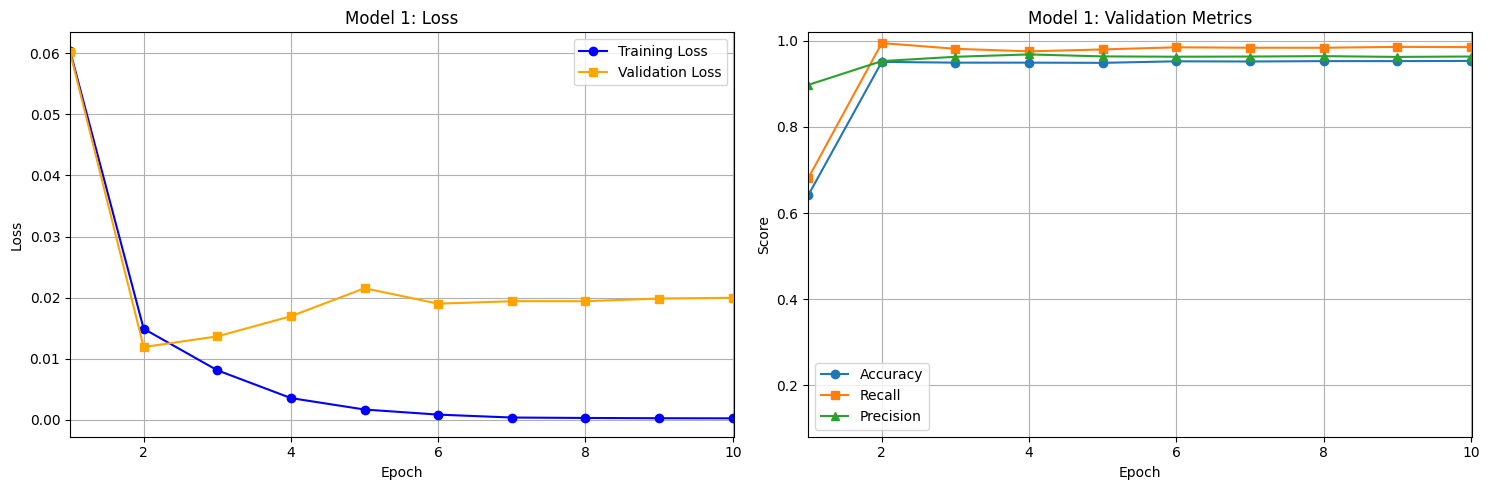

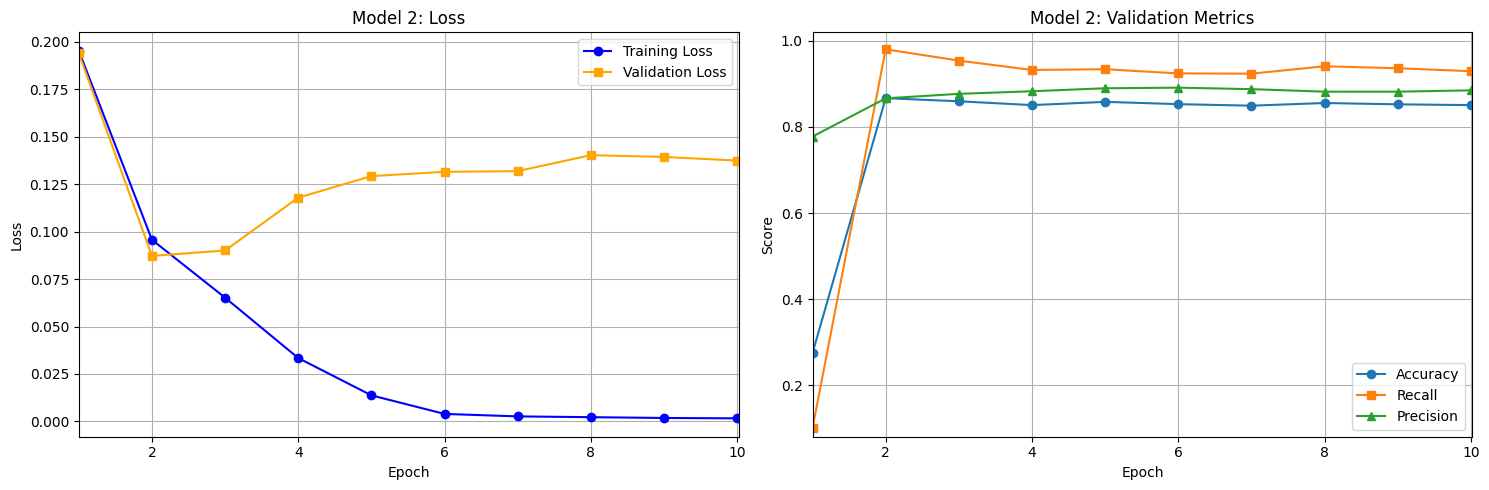

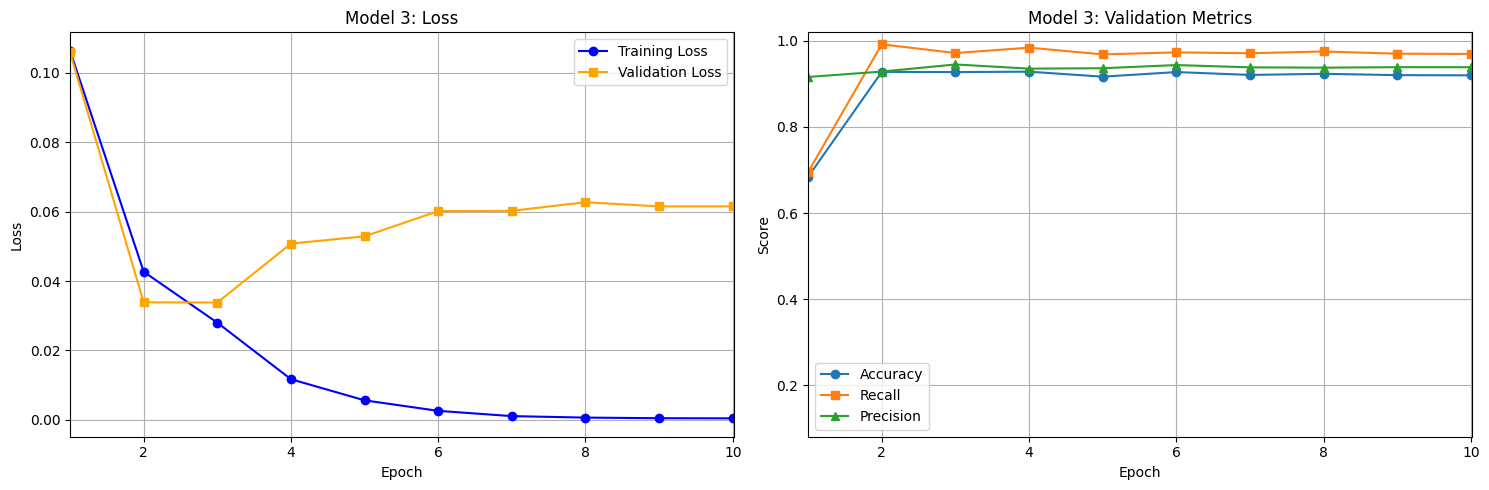

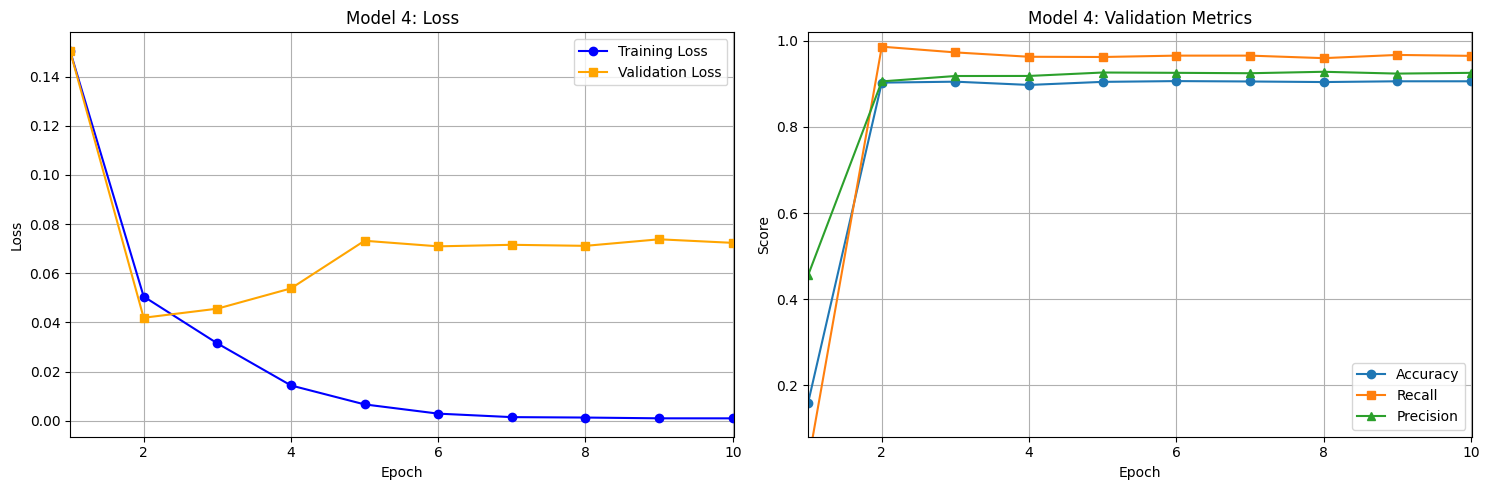

In [23]:
plot_all_models(feature_results)


In [35]:
def process_metrics_losses(best_metrics_losses):
    """
    Processes best metrics and losses to return a DataFrame and confusion matrices.

    Args:
        best_metrics_losses (list): List of dictionaries containing train_loss, val_loss, and metrics for models.

    Returns:
        tuple: (DataFrame of metrics and losses, dictionary of confusion matrices)
    """
    # Prepare lists for DataFrame
    data = {
        "Model": [],
        "Train Loss": [],
        "Validation Loss": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": []
    }

    # Dictionary to store confusion matrices
    confusion_matrices = {}

    # Process each model's metrics and losses
    for i, model_data in enumerate(best_metrics_losses):
        metrics = model_data['metrics']

        # Append data to lists
        data["Model"].append(f"Model {i+1}")
        data["Train Loss"].append(model_data['train_loss'])
        data["Validation Loss"].append(model_data['val_loss'])
        data["Accuracy"].append(metrics['accuracy'])
        data["Precision"].append(metrics['precision'])
        data["Recall"].append(metrics['recall'])
        data["F1 Score"].append(metrics['f1'])

        # Add confusion matrix to dictionary
        confusion_matrices[f"Model {i+1}"] = metrics['cm']

    # Create DataFrame
    df = pd.DataFrame(data)

    return df, confusion_matrices


In [36]:
df32, cm_dict32 = process_metrics_losses(best_metrics_losses)
df32

,Model,Train Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
0,Model 1,0.0002,0.0203,0.953551,0.963338,0.986173,0.974622
1,Model 2,0.0957,0.0872,0.866905,0.866599,0.980560,0.920064
2,Model 3,0.0427,0.0339,0.928093,0.928815,0.992188,0.959456
3,Model 4,0.0029,0.0709,0.906655,0.925869,0.965867,0.945445


## Batch size 64

In [12]:
train_loader_64 = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader_64 = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Debugging: Print shapes of one batch
for images, attribute_labels, final_labels in train_loader_64:
    print("Image Batch Shape:", images.shape)
    print("Attribute Labels Shape:", attribute_labels.shape)
    print("Final Labels Shape:", final_labels.shape)
    break

Image Batch Shape: torch.Size([64, 3, 240, 240])
Attribute Labels Shape: torch.Size([64, 4])
Final Labels Shape: torch.Size([64])


In [13]:
# Initialize feature models with MobileNetV2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_models_64 = [FeatureModel().to(device) for _ in range(4)]

In [17]:
feature_results, best_feature_models,best_metrics_losses = train_and_evaluate(
    feature_models=feature_models_64,
    train_loader=train_loader_64,
    val_loader=val_loader_64,
    device=device,
    epochs=10,
    lr=0.0001
)


Feature Model 1: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 1, Epoch 0: Train Loss: 0.0670, Val Loss: 0.0668, Metrics: {'accuracy': 0.3640017865118356, 'recall': 0.32098765432098764, 'precision': 0.9298998569384835, 'f1': 0.4772393538913362, 'cm': array([[ 165,   49],
       [1375,  650]])}


Feature Model 1, Epoch 1: Train Loss: 0.0166, Val Loss: 0.0123, Metrics: {'accuracy': 0.950870924519875, 'recall': 0.9920987654320987, 'precision': 0.9553019495958155, 'f1': 0.9733527131782945, 'cm': array([[ 120,   94],
       [  16, 2009]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 1, Epoch 1: New best model saved with F1 score 0.9734


Feature Model 1, Epoch 2: Train Loss: 0.0087, Val Loss: 0.0129, Metrics: {'accuracy': 0.9539973202322466, 'recall': 0.9851851851851852, 'precision': 0.9647001934235977, 'f1': 0.9748350842902516, 'cm': array([[ 141,   73],
       [  30, 1995]])}
Epoch 2, Learning Rate: 0.0001
Feature Model 1, Epoch 2: New best model saved with F1 score 0.9748


Feature Model 1, Epoch 3: Train Loss: 0.0044, Val Loss: 0.0155, Metrics: {'accuracy': 0.9535506922733363, 'recall': 0.9896296296296296, 'precision': 0.9602299952084331, 'f1': 0.9747081712062258, 'cm': array([[ 131,   83],
       [  21, 2004]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 1, Epoch 4: Train Loss: 0.0016, Val Loss: 0.0200, Metrics: {'accuracy': 0.9486377847253238, 'recall': 0.985679012345679, 'precision': 0.9586935638808838, 'f1': 0.9719990260530801, 'cm': array([[ 128,   86],
       [  29, 1996]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 1, Epoch 5: Train Loss: 0.0006, Val Loss: 0.0184, Metrics: {'accuracy': 0.9513175524787851, 'recall': 0.9837037037037037, 'precision': 0.9632495164410058, 'f1': 0.9733691668702663, 'cm': array([[ 138,   76],
       [  33, 1992]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 1, Epoch 6: Train Loss: 0.0004, Val Loss: 0.0187, Metrics: {'accuracy': 0.9504242965609647, 'recall': 0.9837037037037037, 'precision': 0.9623188405797102, 'f1': 0.9728937728937729, 'cm': array([[ 136,   78],
       [  33, 1992]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 1, Epoch 7: Train Loss: 0.0004, Val Loss: 0.0187, Metrics: {'accuracy': 0.9499776686020545, 'recall': 0.9817283950617284, 'precision': 0.9636451769268056, 'f1': 0.9726027397260275, 'cm': array([[ 139,   75],
       [  37, 1988]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 1, Epoch 8: Train Loss: 0.0003, Val Loss: 0.0185, Metrics: {'accuracy': 0.9504242965609647, 'recall': 0.9812345679012345, 'precision': 0.9645631067961165, 'f1': 0.9728274173806608, 'cm': array([[ 141,   73],
       [  38, 1987]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 1, Epoch 9: Train Loss: 0.0003, Val Loss: 0.0190, Metrics: {'accuracy': 0.9499776686020545, 'recall': 0.9832098765432099, 'precision': 0.9623006283228613, 'f1': 0.9726428920371275, 'cm': array([[ 136,   78],
       [  34, 1991]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 1, Epoch 10: Train Loss: 0.0003, Val Loss: 0.0188, Metrics: {'accuracy': 0.9499776686020545, 'recall': 0.9812345679012345, 'precision': 0.9640950994662785, 'f1': 0.9725893294175233, 'cm': array([[ 140,   74],
       [  38, 1987]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 2: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 2, Epoch 0: Train Loss: 0.1912, Val Loss: 0.1900, Metrics: {'accuracy': 0.3148727110317106, 'recall': 0.1646655231560892, 'precision': 0.7977839335180056, 'f1': 0.27298578199052137, 'cm': array([[ 417,   73],
       [1461,  288]])}


Feature Model 2, Epoch 1: Train Loss: 0.0965, Val Loss: 0.0832, Metrics: {'accuracy': 0.8682447521214828, 'recall': 0.9788450543167524, 'precision': 0.8690355329949239, 'f1': 0.9206776015057812, 'cm': array([[ 232,  258],
       [  37, 1712]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 2, Epoch 1: New best model saved with F1 score 0.9207


Feature Model 2, Epoch 2: Train Loss: 0.0654, Val Loss: 0.0868, Metrics: {'accuracy': 0.8660116123269317, 'recall': 0.9685534591194969, 'precision': 0.8736462093862816, 'f1': 0.9186550976138829, 'cm': array([[ 245,  245],
       [  55, 1694]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 2, Epoch 3: Train Loss: 0.0306, Val Loss: 0.1072, Metrics: {'accuracy': 0.8378740509155873, 'recall': 0.8873642081189251, 'precision': 0.9033760186263097, 'f1': 0.8952985289875974, 'cm': array([[ 324,  166],
       [ 197, 1552]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 2, Epoch 4: Train Loss: 0.0097, Val Loss: 0.1358, Metrics: {'accuracy': 0.8593121929432782, 'recall': 0.9559748427672956, 'precision': 0.875392670157068, 'f1': 0.9139109046187482, 'cm': array([[ 252,  238],
       [  77, 1672]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 2, Epoch 5: Train Loss: 0.0030, Val Loss: 0.1298, Metrics: {'accuracy': 0.8584189370254578, 'recall': 0.9439679817038308, 'precision': 0.8828877005347594, 'f1': 0.9124067421939763, 'cm': array([[ 271,  219],
       [  98, 1651]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 2, Epoch 6: Train Loss: 0.0020, Val Loss: 0.1302, Metrics: {'accuracy': 0.8566324251898169, 'recall': 0.9416809605488851, 'precision': 0.882636655948553, 'f1': 0.9112033195020746, 'cm': array([[ 271,  219],
       [ 102, 1647]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 2, Epoch 7: Train Loss: 0.0016, Val Loss: 0.1315, Metrics: {'accuracy': 0.8575256811076374, 'recall': 0.9399656946826758, 'precision': 0.8848223896663079, 'f1': 0.9115608538952038, 'cm': array([[ 276,  214],
       [ 105, 1644]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 2, Epoch 8: Train Loss: 0.0016, Val Loss: 0.1306, Metrics: {'accuracy': 0.8579723090665475, 'recall': 0.9382504288164666, 'precision': 0.8865478119935171, 'f1': 0.9116666666666667, 'cm': array([[ 280,  210],
       [ 108, 1641]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 2, Epoch 9: Train Loss: 0.0015, Val Loss: 0.1321, Metrics: {'accuracy': 0.8588655649843681, 'recall': 0.9411092052601486, 'precision': 0.8854222700376546, 'f1': 0.9124168514412417, 'cm': array([[ 277,  213],
       [ 103, 1646]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 2, Epoch 10: Train Loss: 0.0014, Val Loss: 0.1299, Metrics: {'accuracy': 0.8566324251898169, 'recall': 0.9371069182389937, 'precision': 0.885945945945946, 'f1': 0.910808557932759, 'cm': array([[ 279,  211],
       [ 110, 1639]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 3: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 3, Epoch 0: Train Loss: 0.1027, Val Loss: 0.1024, Metrics: {'accuracy': 0.7467619472979008, 'recall': 0.7744791666666667, 'precision': 0.9173349784083898, 'f1': 0.8398757413160124, 'cm': array([[ 185,  134],
       [ 433, 1487]])}


Feature Model 3, Epoch 1: Train Loss: 0.0441, Val Loss: 0.0333, Metrics: {'accuracy': 0.9312192943278249, 'recall': 0.9880208333333333, 'precision': 0.935404339250493, 'f1': 0.9609929078014185, 'cm': array([[ 188,  131],
       [  23, 1897]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 3, Epoch 1: New best model saved with F1 score 0.9610


Feature Model 3, Epoch 2: Train Loss: 0.0257, Val Loss: 0.0356, Metrics: {'accuracy': 0.9213934792317999, 'recall': 0.9708333333333333, 'precision': 0.9395161290322581, 'f1': 0.9549180327868853, 'cm': array([[ 199,  120],
       [  56, 1864]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 3, Epoch 3: Train Loss: 0.0106, Val Loss: 0.0405, Metrics: {'accuracy': 0.929432782492184, 'recall': 0.9760416666666667, 'precision': 0.9436052366565961, 'f1': 0.9595494111623143, 'cm': array([[ 207,  112],
       [  46, 1874]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 3, Epoch 4: Train Loss: 0.0035, Val Loss: 0.0467, Metrics: {'accuracy': 0.9316659222867352, 'recall': 0.984375, 'precision': 0.9388971684053651, 'f1': 0.9610983981693364, 'cm': array([[ 196,  123],
       [  30, 1890]])}
Epoch 4, Learning Rate: 1e-05
Feature Model 3, Epoch 4: New best model saved with F1 score 0.9611


Feature Model 3, Epoch 5: Train Loss: 0.0011, Val Loss: 0.0469, Metrics: {'accuracy': 0.9307726663689146, 'recall': 0.9822916666666667, 'precision': 0.9397110114598903, 'f1': 0.9605296664120192, 'cm': array([[ 198,  121],
       [  34, 1886]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 3, Epoch 6: Train Loss: 0.0008, Val Loss: 0.0463, Metrics: {'accuracy': 0.929432782492184, 'recall': 0.9796875, 'precision': 0.9405, 'f1': 0.9596938775510205, 'cm': array([[ 200,  119],
       [  39, 1881]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 3, Epoch 7: Train Loss: 0.0007, Val Loss: 0.0463, Metrics: {'accuracy': 0.9271996426976329, 'recall': 0.9755208333333333, 'precision': 0.9416792357968828, 'f1': 0.9583013558454848, 'cm': array([[ 203,  116],
       [  47, 1873]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 3, Epoch 8: Train Loss: 0.0007, Val Loss: 0.0476, Metrics: {'accuracy': 0.9289861545332738, 'recall': 0.9791666666666666, 'precision': 0.9404702351175588, 'f1': 0.9594284256187803, 'cm': array([[ 200,  119],
       [  40, 1880]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 3, Epoch 9: Train Loss: 0.0007, Val Loss: 0.0477, Metrics: {'accuracy': 0.9280928986154533, 'recall': 0.9786458333333333, 'precision': 0.9399699849924963, 'f1': 0.9589180913498341, 'cm': array([[ 199,  120],
       [  41, 1879]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 3, Epoch 10: Train Loss: 0.0006, Val Loss: 0.0478, Metrics: {'accuracy': 0.9285395265743636, 'recall': 0.9791666666666666, 'precision': 0.94, 'f1': 0.9591836734693877, 'cm': array([[ 199,  120],
       [  40, 1880]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 4: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 4, Epoch 0: Train Loss: 0.1286, Val Loss: 0.1282, Metrics: {'accuracy': 0.36757481018311744, 'recall': 0.28053333333333336, 'precision': 0.8870151770657673, 'f1': 0.4262560777957861, 'cm': array([[ 297,   67],
       [1349,  526]])}


Feature Model 4, Epoch 1: Train Loss: 0.0537, Val Loss: 0.0434, Metrics: {'accuracy': 0.9048682447521215, 'recall': 0.9904, 'precision': 0.9049707602339181, 'f1': 0.9457601222307105, 'cm': array([[ 169,  195],
       [  18, 1857]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 4, Epoch 1: New best model saved with F1 score 0.9458


Feature Model 4, Epoch 2: Train Loss: 0.0311, Val Loss: 0.0457, Metrics: {'accuracy': 0.905761500669942, 'recall': 0.9749333333333333, 'precision': 0.9176706827309237, 'f1': 0.9454357382984225, 'cm': array([[ 200,  164],
       [  47, 1828]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 4, Epoch 3: Train Loss: 0.0136, Val Loss: 0.0652, Metrics: {'accuracy': 0.8990620812862885, 'recall': 0.9706666666666667, 'precision': 0.9141135107985937, 'f1': 0.9415416451112261, 'cm': array([[ 193,  171],
       [  55, 1820]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 4, Epoch 4: Train Loss: 0.0037, Val Loss: 0.0743, Metrics: {'accuracy': 0.8990620812862885, 'recall': 0.9653333333333334, 'precision': 0.9183155758498224, 'f1': 0.9412376495059801, 'cm': array([[ 203,  161],
       [  65, 1810]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 4, Epoch 5: Train Loss: 0.0012, Val Loss: 0.0735, Metrics: {'accuracy': 0.9021884769986601, 'recall': 0.968, 'precision': 0.9194528875379939, 'f1': 0.9431021044427124, 'cm': array([[ 205,  159],
       [  60, 1815]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 4, Epoch 6: Train Loss: 0.0011, Val Loss: 0.0716, Metrics: {'accuracy': 0.9035283608753908, 'recall': 0.9648, 'precision': 0.9234303215926493, 'f1': 0.9436619718309859, 'cm': array([[ 214,  150],
       [  66, 1809]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 4, Epoch 7: Train Loss: 0.0009, Val Loss: 0.0726, Metrics: {'accuracy': 0.903974988834301, 'recall': 0.9664, 'precision': 0.9226069246435845, 'f1': 0.9439958322479812, 'cm': array([[ 212,  152],
       [  63, 1812]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 8: Train Loss: 0.0008, Val Loss: 0.0721, Metrics: {'accuracy': 0.9030817329164805, 'recall': 0.9648, 'precision': 0.9229591836734694, 'f1': 0.9434159061277706, 'cm': array([[ 213,  151],
       [  66, 1809]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 9: Train Loss: 0.0008, Val Loss: 0.0724, Metrics: {'accuracy': 0.9030817329164805, 'recall': 0.9648, 'precision': 0.9229591836734694, 'f1': 0.9434159061277706, 'cm': array([[ 213,  151],
       [  66, 1809]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 10: Train Loss: 0.0007, Val Loss: 0.0725, Metrics: {'accuracy': 0.9026351049575704, 'recall': 0.9653333333333334, 'precision': 0.9220580743759552, 'f1': 0.9431995831162064, 'cm': array([[ 211,  153],
       [  65, 1810]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07


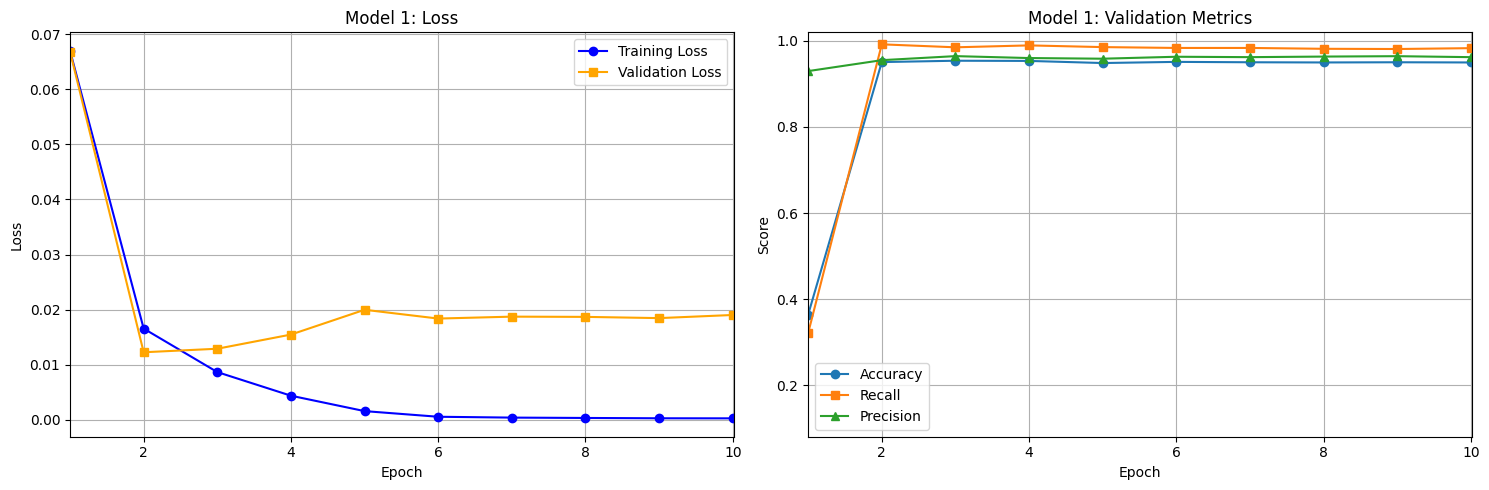

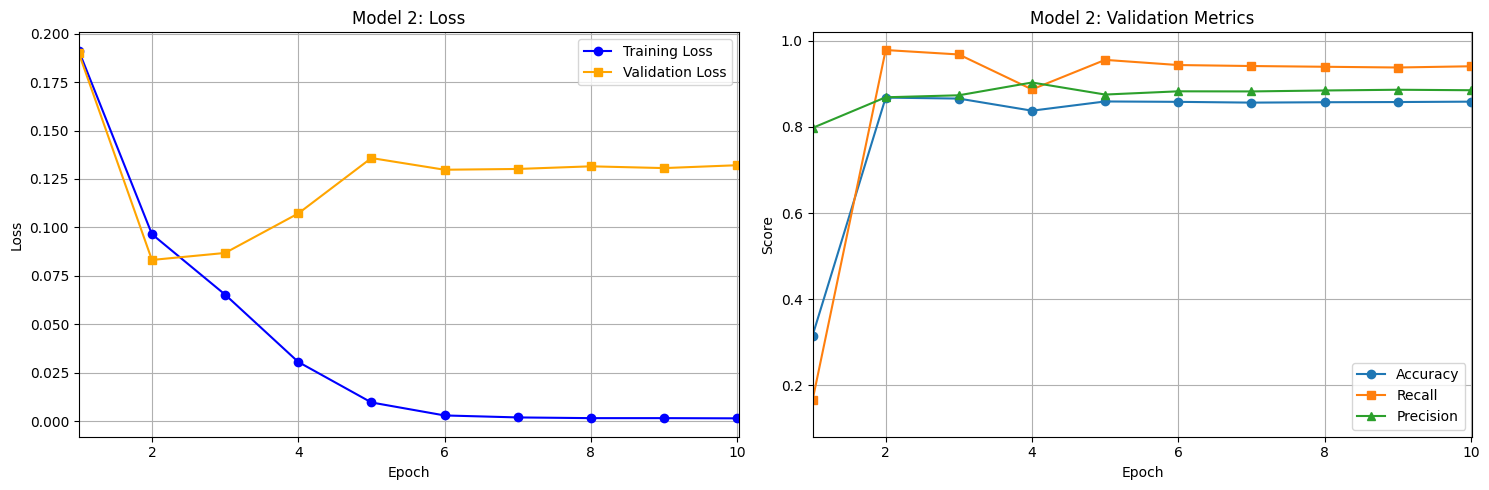

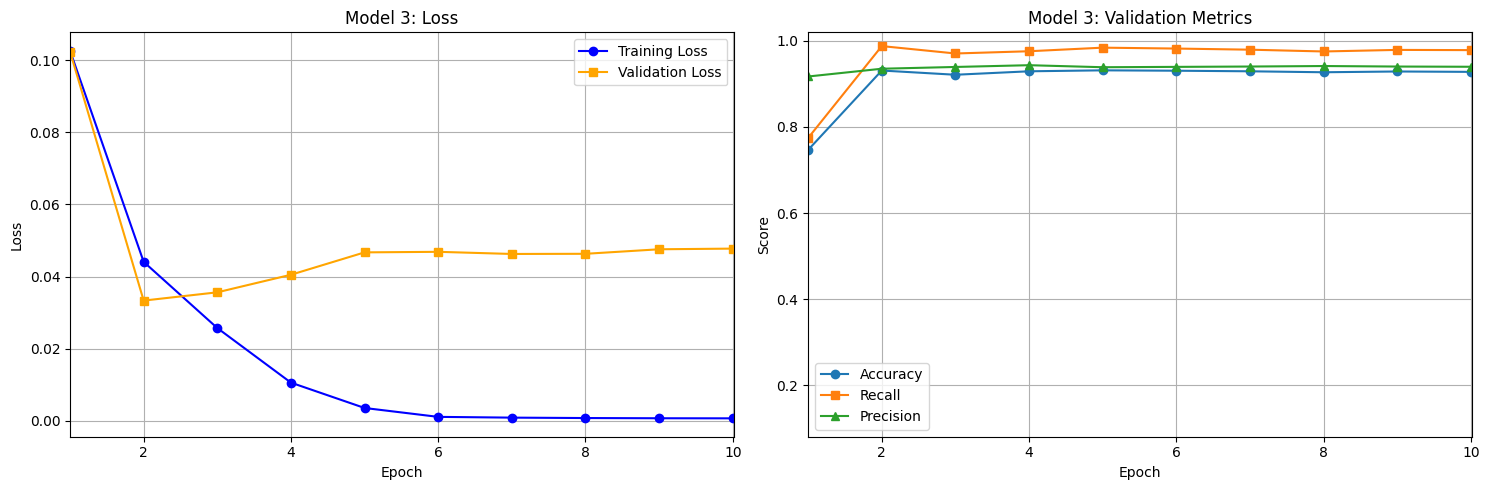

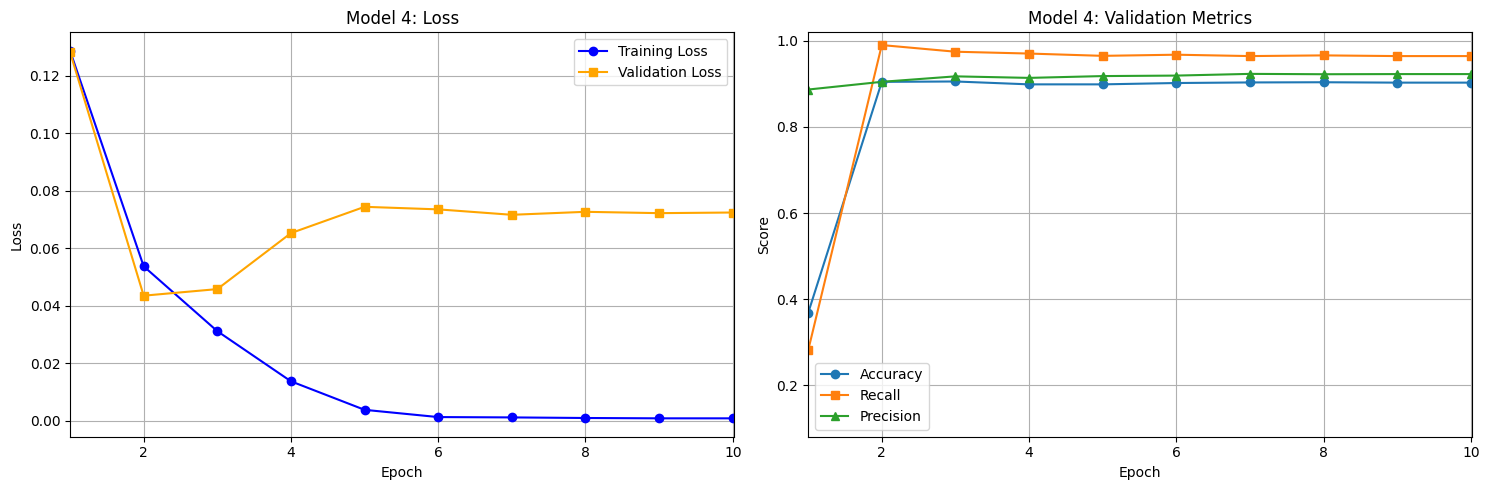

In [20]:
plot_all_models(feature_results)


In [24]:
df64, cm_dict64 = process_metrics_losses(best_metrics_losses)
df64

,Model,Train Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
0,Model 1,0.008687,0.012922,0.953997,0.964700,0.985185,0.974835
1,Model 2,0.096522,0.083223,0.868245,0.869036,0.978845,0.920678
2,Model 3,0.003525,0.046702,0.931666,0.938897,0.984375,0.961098
3,Model 4,0.053650,0.043431,0.904868,0.904971,0.990400,0.945760


## Batch size 128

In [25]:
train_loader_128 = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_128 = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Debugging: Print shapes of one batch
for images, attribute_labels, final_labels in train_loader_128:
    print("Image Batch Shape:", images.shape)
    print("Attribute Labels Shape:", attribute_labels.shape)
    print("Final Labels Shape:", final_labels.shape)
    break

Image Batch Shape: torch.Size([128, 3, 240, 240])
Attribute Labels Shape: torch.Size([128, 4])
Final Labels Shape: torch.Size([128])


In [26]:
# Initialize feature models with MobileNetV2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_models_128 = [FeatureModel().to(device) for _ in range(4)]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
feature_results, best_feature_models,best_metrics_losses = train_and_evaluate(
    feature_models=feature_models_128,
    train_loader=train_loader_128,
    val_loader=val_loader_128,
    device=device,
    epochs=10,
    lr=0.0001
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 1: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 1, Epoch 0: Train Loss: 0.0610, Val Loss: 0.0610, Metrics: {'accuracy': 0.5877623939258597, 'recall': 0.6019753086419753, 'precision': 0.9124251497005988, 'f1': 0.7253793513835167, 'cm': array([[  97,  117],
       [ 806, 1219]])}


Feature Model 1, Epoch 1: Train Loss: 0.0177, Val Loss: 0.0122, Metrics: {'accuracy': 0.9499776686020545, 'recall': 0.9916049382716049, 'precision': 0.9548264384213029, 'f1': 0.9728682170542636, 'cm': array([[ 119,   95],
       [  17, 2008]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 1, Epoch 1: New best model saved with F1 score 0.9729


Feature Model 1, Epoch 2: Train Loss: 0.0087, Val Loss: 0.0126, Metrics: {'accuracy': 0.9544439481911567, 'recall': 0.9876543209876543, 'precision': 0.9629272989889264, 'f1': 0.9751340809361287, 'cm': array([[ 137,   77],
       [  25, 2000]])}
Epoch 2, Learning Rate: 0.0001
Feature Model 1, Epoch 2: New best model saved with F1 score 0.9751


Feature Model 1, Epoch 3: Train Loss: 0.0040, Val Loss: 0.0164, Metrics: {'accuracy': 0.9486377847253238, 'recall': 0.9906172839506173, 'precision': 0.9543292102759277, 'f1': 0.9721347225587594, 'cm': array([[ 118,   96],
       [  19, 2006]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 1, Epoch 4: Train Loss: 0.0015, Val Loss: 0.0168, Metrics: {'accuracy': 0.9477445288075034, 'recall': 0.9846913580246913, 'precision': 0.9586538461538462, 'f1': 0.9714981729598051, 'cm': array([[ 128,   86],
       [  31, 1994]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 1, Epoch 5: Train Loss: 0.0006, Val Loss: 0.0164, Metrics: {'accuracy': 0.9481911567664135, 'recall': 0.9832098765432099, 'precision': 0.9604438012542209, 'f1': 0.9716935090287945, 'cm': array([[ 132,   82],
       [  34, 1991]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 1, Epoch 6: Train Loss: 0.0005, Val Loss: 0.0166, Metrics: {'accuracy': 0.9495310406431443, 'recall': 0.985679012345679, 'precision': 0.9596153846153846, 'f1': 0.9724725943970768, 'cm': array([[ 130,   84],
       [  29, 1996]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 1, Epoch 7: Train Loss: 0.0004, Val Loss: 0.0167, Metrics: {'accuracy': 0.9499776686020545, 'recall': 0.985679012345679, 'precision': 0.9600769600769601, 'f1': 0.9727095516569201, 'cm': array([[ 131,   83],
       [  29, 1996]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 1, Epoch 8: Train Loss: 0.0005, Val Loss: 0.0165, Metrics: {'accuracy': 0.9486377847253238, 'recall': 0.9837037037037037, 'precision': 0.9604628736740598, 'f1': 0.9719443766772384, 'cm': array([[ 132,   82],
       [  33, 1992]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 1, Epoch 9: Train Loss: 0.0005, Val Loss: 0.0165, Metrics: {'accuracy': 0.9472979008485931, 'recall': 0.9822222222222222, 'precision': 0.9604056011588604, 'f1': 0.9711914062499999, 'cm': array([[ 132,   82],
       [  36, 1989]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 1, Epoch 10: Train Loss: 0.0004, Val Loss: 0.0168, Metrics: {'accuracy': 0.9495310406431443, 'recall': 0.985679012345679, 'precision': 0.9596153846153846, 'f1': 0.9724725943970768, 'cm': array([[ 130,   84],
       [  29, 1996]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 2: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 2, Epoch 0: Train Loss: 0.1688, Val Loss: 0.1703, Metrics: {'accuracy': 0.6654756587762394, 'recall': 0.7987421383647799, 'precision': 0.7787068004459309, 'f1': 0.7885972339825006, 'cm': array([[  93,  397],
       [ 352, 1397]])}


Feature Model 2, Epoch 1: Train Loss: 0.0974, Val Loss: 0.0830, Metrics: {'accuracy': 0.8660116123269317, 'recall': 0.9811320754716981, 'precision': 0.8653555219364599, 'f1': 0.9196141479099679, 'cm': array([[ 223,  267],
       [  33, 1716]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 2, Epoch 1: New best model saved with F1 score 0.9196


Feature Model 2, Epoch 2: Train Loss: 0.0662, Val Loss: 0.0850, Metrics: {'accuracy': 0.8633318445734703, 'recall': 0.9519725557461407, 'precision': 0.8823529411764706, 'f1': 0.9158415841584159, 'cm': array([[ 268,  222],
       [  84, 1665]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 2, Epoch 3: Train Loss: 0.0351, Val Loss: 0.1027, Metrics: {'accuracy': 0.8517195176418044, 'recall': 0.9411092052601486, 'precision': 0.8778666666666667, 'f1': 0.9083885209713025, 'cm': array([[ 261,  229],
       [ 103, 1646]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 2, Epoch 4: Train Loss: 0.0110, Val Loss: 0.1253, Metrics: {'accuracy': 0.8584189370254578, 'recall': 0.9548313321898227, 'precision': 0.8752620545073375, 'f1': 0.9133169264424391, 'cm': array([[ 252,  238],
       [  79, 1670]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 2, Epoch 5: Train Loss: 0.0036, Val Loss: 0.1193, Metrics: {'accuracy': 0.8575256811076374, 'recall': 0.9433962264150944, 'precision': 0.8823529411764706, 'f1': 0.911854103343465, 'cm': array([[ 270,  220],
       [  99, 1650]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 2, Epoch 6: Train Loss: 0.0026, Val Loss: 0.1209, Metrics: {'accuracy': 0.8575256811076374, 'recall': 0.9433962264150944, 'precision': 0.8823529411764706, 'f1': 0.911854103343465, 'cm': array([[ 270,  220],
       [  99, 1650]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 2, Epoch 7: Train Loss: 0.0022, Val Loss: 0.1224, Metrics: {'accuracy': 0.8566324251898169, 'recall': 0.9399656946826758, 'precision': 0.8838709677419355, 'f1': 0.9110556940980882, 'cm': array([[ 274,  216],
       [ 105, 1644]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 2, Epoch 8: Train Loss: 0.0020, Val Loss: 0.1218, Metrics: {'accuracy': 0.8552925413130862, 'recall': 0.9393939393939394, 'precision': 0.8828586781300376, 'f1': 0.9102493074792245, 'cm': array([[ 272,  218],
       [ 106, 1643]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 2, Epoch 9: Train Loss: 0.0021, Val Loss: 0.1216, Metrics: {'accuracy': 0.8561857972309067, 'recall': 0.9399656946826758, 'precision': 0.8833960236432026, 'f1': 0.910803324099723, 'cm': array([[ 273,  217],
       [ 105, 1644]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 2, Epoch 10: Train Loss: 0.0019, Val Loss: 0.1219, Metrics: {'accuracy': 0.8561857972309067, 'recall': 0.9399656946826758, 'precision': 0.8833960236432026, 'f1': 0.910803324099723, 'cm': array([[ 273,  217],
       [ 105, 1644]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 3: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 3, Epoch 0: Train Loss: 0.1178, Val Loss: 0.1174, Metrics: {'accuracy': 0.38990620812862886, 'recall': 0.3609375, 'precision': 0.8329326923076923, 'f1': 0.5036337209302325, 'cm': array([[ 180,  139],
       [1227,  693]])}


Feature Model 3, Epoch 1: Train Loss: 0.0491, Val Loss: 0.0329, Metrics: {'accuracy': 0.9325591782045556, 'recall': 0.9927083333333333, 'precision': 0.9329417523250122, 'f1': 0.9618975523593237, 'cm': array([[ 182,  137],
       [  14, 1906]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 3, Epoch 1: New best model saved with F1 score 0.9619


Feature Model 3, Epoch 2: Train Loss: 0.0274, Val Loss: 0.0340, Metrics: {'accuracy': 0.9276462706565431, 'recall': 0.9833333333333333, 'precision': 0.9355797819623389, 'f1': 0.9588623666835957, 'cm': array([[ 189,  130],
       [  32, 1888]])}
Epoch 2, Learning Rate: 0.0001


Feature Model 3, Epoch 3: Train Loss: 0.0138, Val Loss: 0.0422, Metrics: {'accuracy': 0.9280928986154533, 'recall': 0.9885416666666667, 'precision': 0.9317623956799215, 'f1': 0.9593126105635583, 'cm': array([[ 180,  139],
       [  22, 1898]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 3, Epoch 4: Train Loss: 0.0042, Val Loss: 0.0431, Metrics: {'accuracy': 0.9249665029030817, 'recall': 0.9791666666666666, 'precision': 0.9362549800796812, 'f1': 0.9572301425661914, 'cm': array([[ 191,  128],
       [  40, 1880]])}
Epoch 4, Learning Rate: 1e-05


Feature Model 3, Epoch 5: Train Loss: 0.0017, Val Loss: 0.0428, Metrics: {'accuracy': 0.9222867351496203, 'recall': 0.9734375, 'precision': 0.9382530120481928, 'f1': 0.955521472392638, 'cm': array([[ 196,  123],
       [  51, 1869]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 3, Epoch 6: Train Loss: 0.0013, Val Loss: 0.0434, Metrics: {'accuracy': 0.925413130861992, 'recall': 0.9765625, 'precision': 0.9389083625438157, 'f1': 0.9573653306101608, 'cm': array([[ 197,  122],
       [  45, 1875]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 3, Epoch 7: Train Loss: 0.0012, Val Loss: 0.0440, Metrics: {'accuracy': 0.925413130861992, 'recall': 0.9765625, 'precision': 0.9389083625438157, 'f1': 0.9573653306101608, 'cm': array([[ 197,  122],
       [  45, 1875]])}
Epoch 7, Learning Rate: 1.0000000000000002e-06


Feature Model 3, Epoch 8: Train Loss: 0.0012, Val Loss: 0.0442, Metrics: {'accuracy': 0.9258597588209022, 'recall': 0.978125, 'precision': 0.938061938061938, 'f1': 0.9576746557878633, 'cm': array([[ 195,  124],
       [  42, 1878]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 3, Epoch 9: Train Loss: 0.0011, Val Loss: 0.0439, Metrics: {'accuracy': 0.9245198749441715, 'recall': 0.9755208333333333, 'precision': 0.9388471177944863, 'f1': 0.9568326947637292, 'cm': array([[ 197,  122],
       [  47, 1873]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Feature Model 3, Epoch 10: Train Loss: 0.0011, Val Loss: 0.0439, Metrics: {'accuracy': 0.9245198749441715, 'recall': 0.9744791666666667, 'precision': 0.939728779507785, 'f1': 0.956788545129123, 'cm': array([[ 199,  120],
       [  49, 1871]])}
Epoch 10, Learning Rate: 1.0000000000000002e-07
Feature Model 4: Evaluating metrics for Epoch 0 (Before Training)


Feature Model 4, Epoch 0: Train Loss: 0.1182, Val Loss: 0.1182, Metrics: {'accuracy': 0.6547565877623939, 'recall': 0.6650666666666667, 'precision': 0.8958333333333334, 'f1': 0.7633914906642179, 'cm': array([[ 219,  145],
       [ 628, 1247]])}


Feature Model 4, Epoch 1: Train Loss: 0.0569, Val Loss: 0.0441, Metrics: {'accuracy': 0.9048682447521215, 'recall': 0.9877333333333334, 'precision': 0.9069539666993144, 'f1': 0.9456216492213427, 'cm': array([[ 174,  190],
       [  23, 1852]])}
Epoch 1, Learning Rate: 0.0001
Feature Model 4, Epoch 1: New best model saved with F1 score 0.9456


Feature Model 4, Epoch 2: Train Loss: 0.0332, Val Loss: 0.0439, Metrics: {'accuracy': 0.9066547565877624, 'recall': 0.9792, 'precision': 0.9152542372881356, 'f1': 0.9461479000257667, 'cm': array([[ 194,  170],
       [  39, 1836]])}
Epoch 2, Learning Rate: 0.0001
Feature Model 4, Epoch 2: New best model saved with F1 score 0.9461


Feature Model 4, Epoch 3: Train Loss: 0.0170, Val Loss: 0.0549, Metrics: {'accuracy': 0.8977221974095578, 'recall': 0.9578666666666666, 'precision': 0.9229188078108942, 'f1': 0.9400680450143942, 'cm': array([[ 214,  150],
       [  79, 1796]])}
Epoch 3, Learning Rate: 0.0001


Feature Model 4, Epoch 4: Train Loss: 0.0059, Val Loss: 0.0733, Metrics: {'accuracy': 0.9030817329164805, 'recall': 0.9765333333333334, 'precision': 0.9136726546906188, 'f1': 0.9440577468419696, 'cm': array([[ 191,  173],
       [  44, 1831]])}
Epoch 4, Learning Rate: 0.0001


Feature Model 4, Epoch 5: Train Loss: 0.0024, Val Loss: 0.0700, Metrics: {'accuracy': 0.8986154533273782, 'recall': 0.9637333333333333, 'precision': 0.9191251271617498, 'f1': 0.9409008070814892, 'cm': array([[ 205,  159],
       [  68, 1807]])}
Epoch 5, Learning Rate: 1e-05


Feature Model 4, Epoch 6: Train Loss: 0.0010, Val Loss: 0.0685, Metrics: {'accuracy': 0.8972755694506476, 'recall': 0.9616, 'precision': 0.9194288628250893, 'f1': 0.9400417101147028, 'cm': array([[ 206,  158],
       [  72, 1803]])}
Epoch 6, Learning Rate: 1e-05


Feature Model 4, Epoch 7: Train Loss: 0.0010, Val Loss: 0.0686, Metrics: {'accuracy': 0.8977221974095578, 'recall': 0.9610666666666666, 'precision': 0.9203268641470889, 'f1': 0.9402556744064701, 'cm': array([[ 208,  156],
       [  73, 1802]])}
Epoch 7, Learning Rate: 1e-05


Feature Model 4, Epoch 8: Train Loss: 0.0009, Val Loss: 0.0694, Metrics: {'accuracy': 0.8981688253684681, 'recall': 0.9621333333333333, 'precision': 0.9199388067312596, 'f1': 0.9405630865484881, 'cm': array([[ 207,  157],
       [  71, 1804]])}
Epoch 8, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 9: Train Loss: 0.0008, Val Loss: 0.0696, Metrics: {'accuracy': 0.8990620812862885, 'recall': 0.9632, 'precision': 0.9200203769740194, 'f1': 0.9411151641479938, 'cm': array([[ 207,  157],
       [  69, 1806]])}
Epoch 9, Learning Rate: 1.0000000000000002e-06


Feature Model 4, Epoch 10: Train Loss: 0.0008, Val Loss: 0.0694, Metrics: {'accuracy': 0.8981688253684681, 'recall': 0.9616, 'precision': 0.9203675344563553, 'f1': 0.9405320813771519, 'cm': array([[ 208,  156],
       [  72, 1803]])}
Epoch 10, Learning Rate: 1.0000000000000002e-06


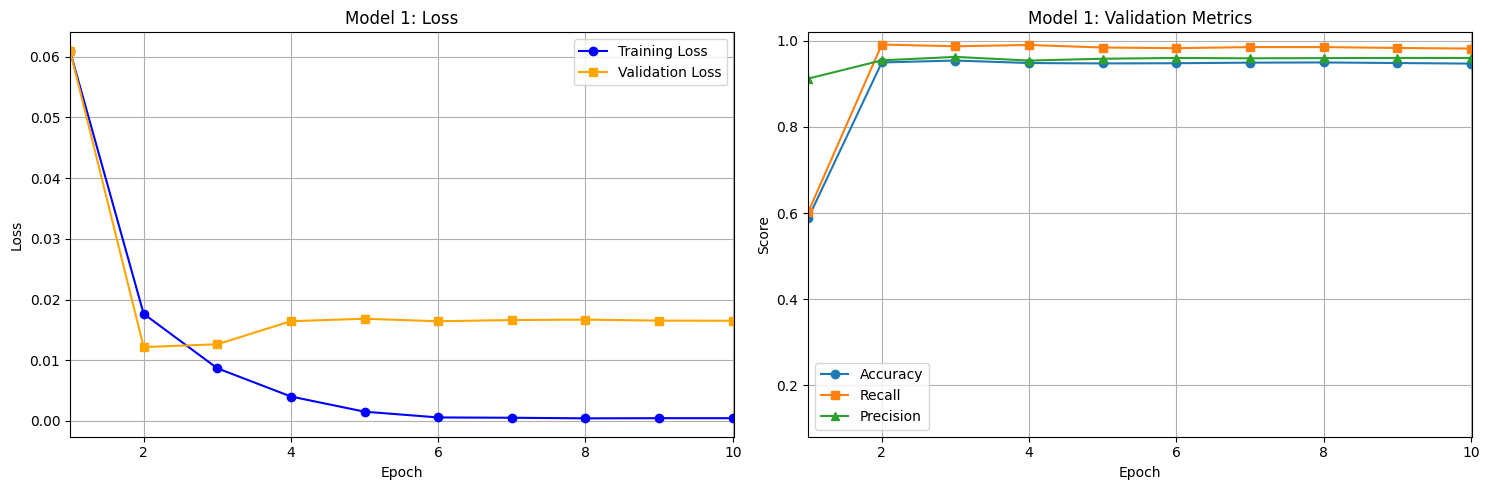

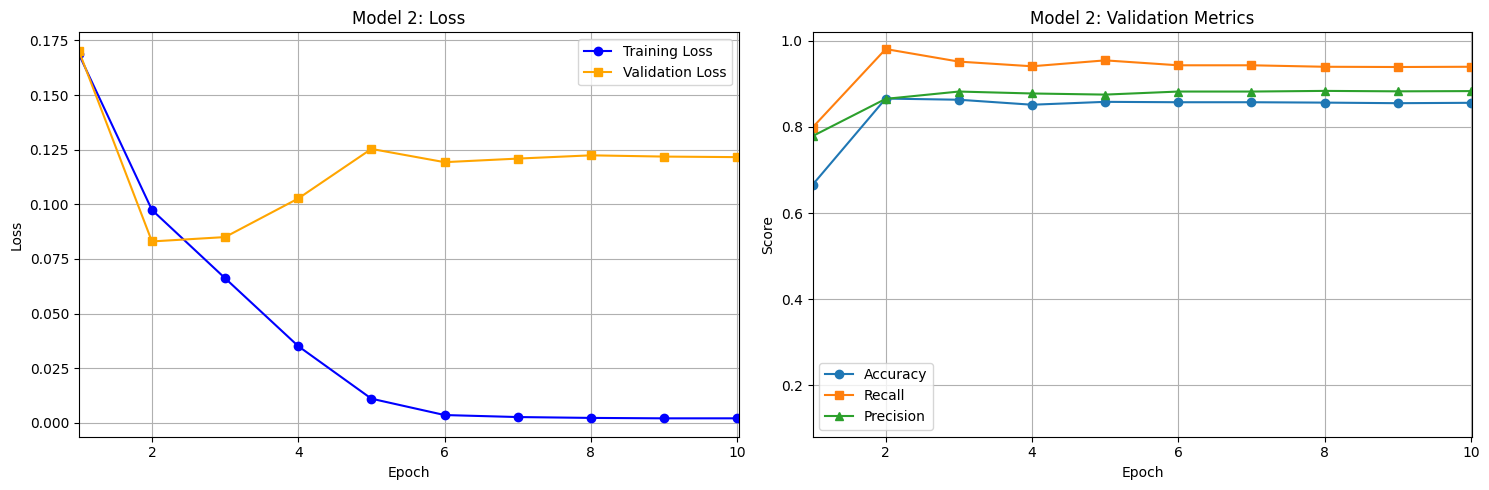

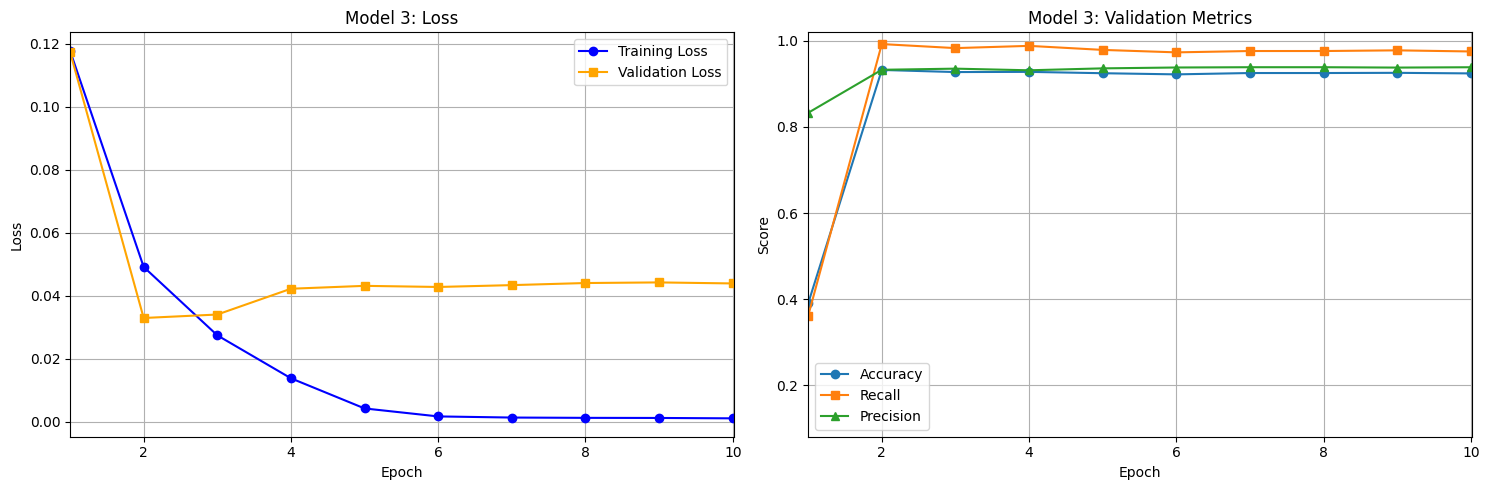

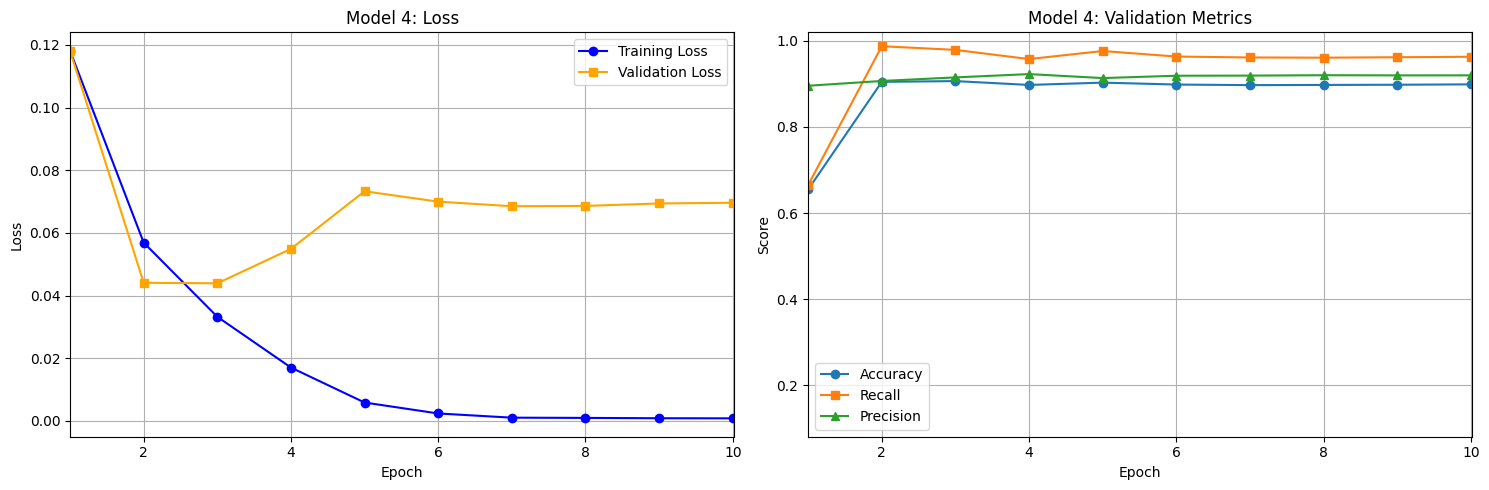

In [28]:
plot_all_models(feature_results)

In [29]:
df128, cm_dict128 = process_metrics_losses(best_metrics_losses)
df128

,Model,Train Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
0,Model 1,0.008684,0.012637,0.954444,0.962927,0.987654,0.975134
1,Model 2,0.097423,0.083004,0.866012,0.865356,0.981132,0.919614
2,Model 3,0.049133,0.032926,0.932559,0.932942,0.992708,0.961898
3,Model 4,0.033247,0.043924,0.906655,0.915254,0.979200,0.946148


# Meta Models

In [ ]:
def collect_feature_outputs(feature_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []  # Store images for later use

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        
        if((batch_idx+1)%20==0):
            print(f"Processing batch {batch_idx + 1}/{len(loader)}")
        
        # Move labels to GPU (images will be processed per model)
        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU for now
        
        # Collect outputs for all feature models
        feature_outputs = []
        for model_idx, model in enumerate(feature_models):
            model = model.to(device)  # Ensure the model is on the device
            
            # Process images batch for this model
            with torch.no_grad():
                outputs = model(images.to(device)).detach().cpu()  # Compute and move to CPU
                feature_outputs.append(outputs)
                # print(f"feature model {model_idx + 1} outputs collected.")
        
        # Concatenate outputs for all feature models
        feature_outputs = torch.cat(feature_outputs, dim=1)  # Concatenate all feature outputs
        meta_inputs.append(feature_outputs)  # Store only feature outputs
        meta_labels.append(final_labels.cpu())  # Move labels to CPU
        
        # # Clean up GPU memory after processing all models for the current batch
        # del images, attribute_labels, final_labels, outputs, feature_outputs
        # torch.cuda.empty_cache()
    
    # Return the collected meta inputs, labels, and images
    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [ ]:

# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_feature_outputs(best_feature_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)


In [ ]:
# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_feature_outputs(best_feature_models, val_loader)

# Create a dataset with images, meta_inputs, and labels
meta_val_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_val_loader = DataLoader(meta_val_dataset, batch_size=32, shuffle=True)

In [ ]:
len(meta_dataset), len(meta_val_dataset)

# Evaluating Simple (if-else )meta Model without any Backbone

In [ ]:
def evaluate_simple_meta_model(meta_loader, meta_val_loader, device):
    """
    Evaluate a simple meta-model that predicts 1 if all feature model outputs are 1, else 0.

    Args:
        meta_loader: DataLoader providing feature model outputs and ground truth labels for training data.
        meta_val_loader: DataLoader providing feature model outputs and ground truth labels for validation data.
        device: Device to use for computation (e.g., 'cuda' or 'cpu').

    Returns:
        results: A dictionary containing metrics for training and validation data.
    """
    def compute_predictions_and_metrics(loader, phase):
        all_labels = []
        all_predictions = []
        loader_tqdm = tqdm(loader, desc=f"Evaluating {phase} Data", leave=False)

        with torch.no_grad():
            for _, feature_outputs, labels in loader_tqdm:
                # Move feature_outputs and labels to the appropriate device
                feature_outputs, labels = feature_outputs.to(device), labels.to(device)

                binary_outputs = (feature_outputs >= 0.5).float()
                # Predict 1 if all feature outputs are 1, else 0
                predictions = (binary_outputs.prod(dim=1) == 1).float()

                # Collect labels and predictions
                all_labels.append(labels.cpu())
                all_predictions.append(predictions.cpu())

        # Concatenate all labels and predictions
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)

        # Compute metrics
        metrics = compute_metrics(all_labels, all_predictions)
        print(f"{phase} Metrics: {metrics}")

        return metrics

    results = {
        "training_metrics": compute_predictions_and_metrics(meta_loader, "Training"),
        "validation_metrics": compute_predictions_and_metrics(meta_val_loader, "Validation"),
    }

    return results


In [ ]:
results = evaluate_simple_meta_model(meta_loader, meta_val_loader, device='cuda')

print("Training Metrics:", results["training_metrics"])
print("Validation Metrics:", results["validation_metrics"])


In [ ]:
# Create DataFrame
metrics_df = pd.DataFrame({
    'Metric': results["training_metrics"].keys(),
    'Training': results["training_metrics"].values(),
    'Validation': results["validation_metrics"].values()
})

metrics_df[:-1]


In [ ]:
metrics_df[4:]['Validation'].item()

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=metrics_df[4:]['Validation'].item(), display_labels=["Class 0", "Class 1"])
# Plot confusion matrix
disp.plot(cmap="magma", values_format='d')
plt.title(f"Confusion Matrix for val_meta_Model")
plt.show()

# Train meta-model with backbone

In [ ]:
def train_meta_model(meta_model, meta_loader, meta_val_loader, meta_optimizer, criterion, device, num_epochs=10, save_path="best_meta_model.pth"):
    """
    Train the meta-model and collect metrics for plotting, including 0th epoch metrics.

    Args:
        meta_model: The meta-model to train.
        meta_loader: DataLoader for training data.
        meta_val_loader: DataLoader for validation data.
        meta_optimizer: Optimizer for the meta-model.
        criterion: Loss function.
        device: Device to use for training (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train for.
        save_path: File path to save the best meta-model.

    Returns:
        results: A dictionary containing training and validation losses and metrics for each epoch.
        best_meta_model: The meta-model with the best validation performance based on f1 score.
    """
    results = {
        "train_loss": [],
        "val_loss": [],
        "metrics": []
    }

    best_f1_score = float("-inf")
    best_meta_model = None

    # 0th epoch validation
    meta_model.eval()
    all_labels = []
    all_predictions = []
    val_total_loss = 0

    # Compute training loss at epoch 0
    train_total_loss = 0
    with torch.no_grad():
        for images, feature_outputs, labels in tqdm(meta_loader, desc="Training Loss (Epoch 0)", leave=False):
            images, feature_outputs, labels = images.to(device), feature_outputs.to(device), labels.to(device)
            outputs = meta_model(images, feature_outputs)  # Pass both images and feature_outputs
            loss = criterion(outputs.squeeze(-1), labels)
            train_total_loss += loss.item()
    train_avg_loss = train_total_loss / len(meta_loader)
    results["train_loss"].append(train_avg_loss)

    # Validation at epoch 0
    print(f"Epoch 0 - Initial Validation Phase")
    with torch.no_grad():
        for images, feature_outputs, labels in tqdm(meta_val_loader, desc="Validation Epoch 0", leave=False):
            images, feature_outputs, labels = images.to(device), feature_outputs.to(device), labels.to(device)
            outputs = meta_model(images, feature_outputs)  # Pass both images and feature_outputs
            loss = criterion(outputs.squeeze(-1), labels)
            val_total_loss += loss.item()
            all_labels.append(labels.cpu())
            all_predictions.append(outputs.cpu())

    val_avg_loss = val_total_loss / len(meta_val_loader)
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)
    metrics = compute_metrics(all_labels, all_predictions)

    results["val_loss"].append(val_avg_loss)
    results["metrics"].append(metrics)

    # Save the model if it's the best so far based on f1 score
    if metrics["f1"] > best_f1_score:
        best_f1_score = metrics["f1"]
        best_meta_model = meta_model.state_dict()
        torch.save(best_meta_model, save_path)

    print(f"Meta Model Epoch 0: Initial Training Loss: {train_avg_loss:.4f}")
    print(f"Meta Model Epoch 0: Initial Validation Loss: {val_avg_loss:.4f}")
    print(f"Meta Model Epoch 0: Initial Validation Metrics: {metrics}")

    # Training and validation for subsequent epochs
    for epoch in range(1, num_epochs + 1):
        # Training phase
        meta_model.train()
        train_total_loss = 0

        print(f"Epoch {epoch}/{num_epochs} - Training Phase")
        for images, feature_outputs, labels in tqdm(meta_loader, desc=f"Training Epoch {epoch}/{num_epochs}", leave=False):
            images, feature_outputs, labels = images.to(device), feature_outputs.to(device), labels.to(device)

            meta_optimizer.zero_grad()
            outputs = meta_model(images, feature_outputs).squeeze(-1)  # Pass both images and feature_outputs
            loss = criterion(outputs, labels)
            loss.backward()
            meta_optimizer.step()

            train_total_loss += loss.item()

        train_avg_loss = train_total_loss / len(meta_loader)
        results["train_loss"].append(train_avg_loss)
        print(f"Meta Model Epoch {epoch}: Average Training Loss: {train_avg_loss:.4f}")

        # Validation phase
        meta_model.eval()
        val_total_loss = 0
        all_labels = []
        all_predictions = []

        print(f"Epoch {epoch}/{num_epochs} - Validation Phase")
        with torch.no_grad():
            for images, feature_outputs, labels in tqdm(meta_val_loader, desc=f"Validation Epoch {epoch}/{num_epochs}", leave=False):
                images, feature_outputs, labels = images.to(device), feature_outputs.to(device), labels.to(device)
                outputs = meta_model(images, feature_outputs)  # Pass both images and feature_outputs
                loss = criterion(outputs.squeeze(-1), labels)
                val_total_loss += loss.item()
                all_labels.append(labels.cpu())
                all_predictions.append(outputs.cpu())

        val_avg_loss = val_total_loss / len(meta_val_loader)
        all_labels = torch.cat(all_labels)
        all_predictions = torch.cat(all_predictions)
        metrics = compute_metrics(all_labels, all_predictions)

        results["val_loss"].append(val_avg_loss)
        results["metrics"].append(metrics)
        print(f"Meta Model Epoch {epoch}: Validation Loss: {val_avg_loss:.4f}")
        print(f"Meta Model Epoch {epoch}: Validation Metrics: {metrics}")

        # Save the model if it's the best so far based on f1 score
        if metrics["f1"] > best_f1_score:
            best_f1_score = metrics["f1"]
            best_meta_model = meta_model.state_dict()
            torch.save(best_meta_model, save_path)
            print(f"Meta Model Epoch {epoch}: Best model saved with f1 score {best_f1_score:.4f}")

    # Load the best meta model
    meta_model.load_state_dict(torch.load(save_path))
    print("Best meta-model restored.")

    return results, meta_model


## Meta model with feature representation

In [ ]:
# Meta Model
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        # Convolutional backbone for the image input
        self.image_backbone = mobilenet_v2(pretrained=True)
        self.image_backbone.classifier = nn.Linear(1280, 128)  # Feature vector for the image
        
        # Fully connected layers to combine image features and feature model outputs
        self.fc = nn.Sequential(
            nn.Linear(128 * 5, 64),  # 128 (image features) + 4 * (feature model outputs 128)
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: Final decision
        )

    def forward(self, image, feature_outputs):
        # Extract features from the image
        image_features = self.image_backbone(image)  # Shape: [batch_size, 128]
        
        # Concatenate image features and feature model outputs
        combined = torch.cat([image_features, feature_outputs], dim=1)  # Shape: [batch_size, 128 + 4]
        
        # Predict final decision
        return torch.sigmoid(self.fc(combined))  # Output probability



In [ ]:
# Function to collect feature outputs
def collect_feature_outputs(feature_models, loader, device='cuda'):
    meta_inputs = []
    meta_labels = []
    all_images = []

    for batch_idx, (images, attribute_labels, final_labels) in enumerate(loader):
        if (batch_idx + 1) % 20 == 0:
            print(f"Processing batch {batch_idx + 1}/{len(loader)}")

        final_labels = final_labels.to(device)
        all_images.append(images.cpu())  # Keep images on CPU
        feature_outputs = []

        for model in feature_models:
            feature_extraction_model = nn.Sequential(*list(model.children())[:-1])  # Remove last layer
            feature_extraction_model.eval()  # Set to eval mode
            feature_extraction_model = feature_extraction_model.to(device)

            with torch.no_grad():
                outputs = feature_extraction_model(images.to(device)).detach().cpu()
                feature_outputs.append(outputs)

        feature_outputs = torch.cat(feature_outputs, dim=1)  # Concatenate all feature outputs
        meta_inputs.append(feature_outputs)
        meta_labels.append(final_labels.cpu())

    return torch.cat(meta_inputs), torch.cat(meta_labels), torch.cat(all_images)


In [ ]:

# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_feature_outputs(best_feature_models, train_loader)

# Create a dataset with images, meta_inputs, and labels
meta_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_train_loader = DataLoader(meta_dataset, batch_size=32, shuffle=True)


In [ ]:
# Prepare meta-model training data
meta_inputs, meta_labels, images = collect_feature_outputs(best_feature_models, val_loader)

# Create a dataset with images, meta_inputs, and labels
meta_val_dataset = TensorDataset(images, meta_inputs, meta_labels)

# Use DataLoader with a smaller batch size
meta_val_loader = DataLoader(meta_val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Initialize the Meta Model
meta_model = MetaModel().to(device)  # Ensure the model is moved to the correct device

# Define optimizer and loss function
meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-4)
weight = torch.tensor([0.2855 / 0.7145]).to(device)
criterion = nn.BCELoss(weight = weight)  # Binary Cross-Entropy Loss for binary classification

# Train the meta-model and collect results
meta_results, best_meta_model = train_meta_model(
    meta_model=meta_model,
    meta_loader=meta_train_loader,
    meta_val_loader = meta_val_loader,
    meta_optimizer=meta_optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10
)